# Mathematical Modeling Project
## Measuring the leverage of FX rates and financial, econometrical indices onto the grain prices based on the major grain importer countries

For data collection first I located countries with the largest amount of grain import using TradeMap.org. I used the first 5 match, namely turkey, Indonesia, china, Italy and Egypt. For locating the largest grain importers I used the grain import volume in 2023.
Then from Bloomberg I downloaded the main financial and economic indices that I thought to have the largest impact on grain prices. This was namely fx rates, money supply, fx reserves, cpi, ppi, gdp, equity indices, 10 year yields and other sentiment indices where they were available.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

### 1. Data Preprocessing

In [5]:
#read input files 
china = pd.read_excel('C:/Users/Dell/Documents/Tananyagok/ELTE-TTK/Mathematical Modeling Practice/data/china.xlsx','monthly',skiprows = 3)
turkey = pd.read_excel('C:/Users/Dell/Documents/Tananyagok/ELTE-TTK/Mathematical Modeling Practice/data/turkey.xlsx','monthly',skiprows = 3)
indonesia = pd.read_excel('C:/Users/Dell/Documents/Tananyagok/ELTE-TTK/Mathematical Modeling Practice/data/indonesia.xlsx','monthly',skiprows = 3)
italy = pd.read_excel('C:/Users/Dell/Documents/Tananyagok/ELTE-TTK/Mathematical Modeling Practice/data/italy.xlsx','monthly',skiprows = 3)
egypt = pd.read_excel('C:/Users/Dell/Documents/Tananyagok/ELTE-TTK/Mathematical Modeling Practice/data/egypt.xlsx','monthly',skiprows = 3)

wheat_price = pd.read_excel('C:/Users/Dell/Documents/Tananyagok/ELTE-TTK/Mathematical Modeling Practice/data/wheat_prices.xlsx','input')
wheat_price = wheat_price[(wheat_price['Date']>'2010-01-01') & (wheat_price['Date']<'2024-10-01')] 
wheat_price = wheat_price.set_index('Date')

wheat_price.index = wheat_price.index + pd.offsets.MonthEnd(0) #some dates are not for month end which causes NaN rows later

geo_index = pd.read_csv('C:/Users/Dell/Documents/Tananyagok/ELTE-TTK/Mathematical Modeling Practice/data/GeoRisk_Ivkovic.csv',delimiter = ';')
geo_index = geo_index[(geo_index['Date']>'2010-01-01') & (geo_index['Date']<'2024-10-01')] 
geo_index = geo_index.set_index('Date')

country_dict = {"china":china, "turkey":turkey, "indonesia":indonesia, "italy":italy, "egypt":egypt}


In [6]:
#Handle missing data
def missing_data(input_df, country):
    missing_data = input_df.isnull().sum().sort_values(ascending=False)
    missing_percent = (input_df.isnull().sum() / len(input_df)) * 100
    missing_data = pd.concat([missing_data, missing_percent], axis=1, keys=['Total', 'Percent'])
    print(missing_percent)
    
    #drop cols if missing too much data
    cols_to_drop = missing_data[missing_data['Percent'] > 20].index
    input_df.drop(cols_to_drop, axis=1, inplace = True)
    print("Columns dropped:", cols_to_drop) 
    #backward fill missing values:
    input_df = input_df.ffill()
    return input_df
    
for country, df in country_dict.items():
    df = df[df['Date']>'2010-01-01']
    df = df[df['Date']<'2024-10-01']
      # Drop rows where 'Date' is NaN
    df = df[~df['Date'].isna()]
    df = missing_data(df, country)
    country_dict[country] = df
    print(df.shape)

Date                                      0.000000
china_consumer_confidence_index           0.000000
China_Composit PMI Output                47.457627
china_money_supply_m2                     0.000000
CNY/USD                                   0.000000
china_fx_reserves                         0.000000
china_ppi                                 0.000000
china_cpi                                 0.000000
china_gdp                                 0.000000
china_equity_shanghai_composite_index     0.000000
china_10y_yield                           0.000000
dtype: float64
Columns dropped: Index(['China_Composit PMI Output'], dtype='object')
(177, 10)
Date                                     0.0
turkey_10y_yield                         0.0
turkey_money_supply_m2                   0.0
turkey_cpi                               0.0
turkey_ppi                               0.0
turkey_international_reserves_ex_gold    0.0
turkey_current_account_balance           0.0
turkey_equity_index          

In [7]:
#Standardization
def standardize_data(df):
    # Apply Standardization using StandardScaler
    scaler = StandardScaler()

    num_cols = df.select_dtypes(include=['int64', 'float64']).columns

    # Fit the scaler on the training data and transform it
    features_scaled = scaler.fit_transform(df[num_cols])
    # Convert the result back to a DataFrame for easy visualization
    df[num_cols] = features_scaled
    # Display the first few rows of the standardized data
    return df
    
st_country_dict = {}
for country,df in country_dict.items():
    standardized_df = standardize_data(df)
    st_country_dict[country] = standardized_df

### 2. Run PCA to see how variance is explained

Using PCA to explore the most relevant features in variance
First I use PCA on each country's data then on the whole dataset to see how many features are required to explain the variance in data.
Then I apply a 5 year rolling window and fit PCA on each window to see the changing composition of loadings in the first PCs.

        Date  china_consumer_confidence_index  china_money_supply_m2  \
2 2024-09-30                        -1.789503               1.938862   

    CNY/USD  china_fx_reserves  china_ppi  china_cpi  china_gdp  \
2  1.177962           0.284766  -0.852344   -1.22258  -0.403351   

   china_equity_shanghai_composite_index  china_10y_yield  
2                               0.846913        -2.079142  


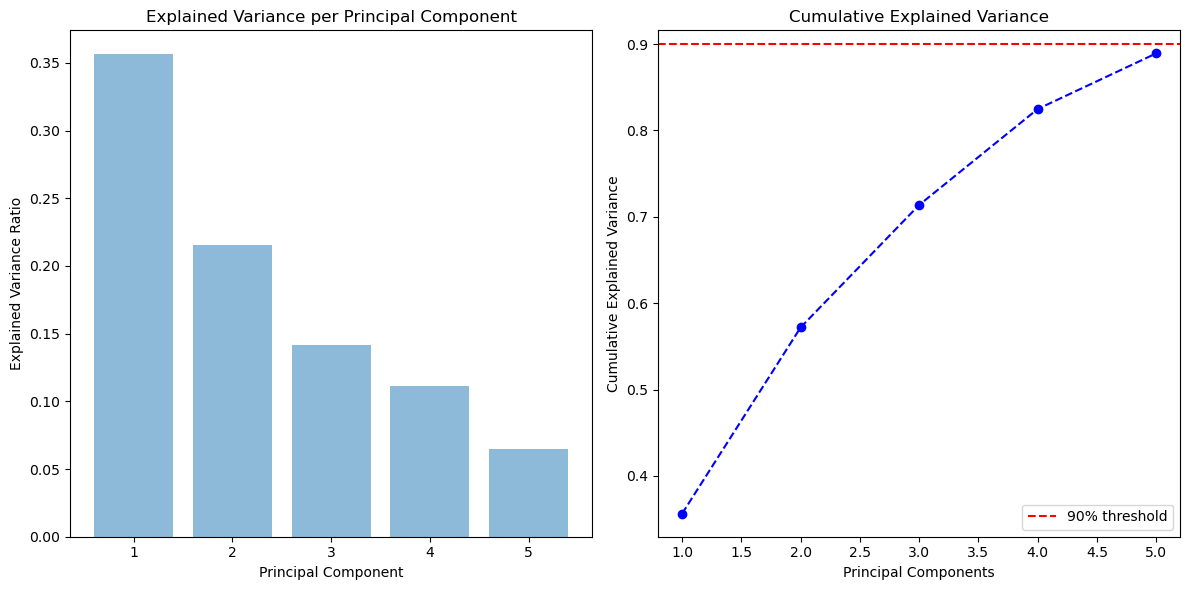

        Date  turkey_10y_yield  turkey_money_supply_m2  turkey_cpi  \
2 2024-09-30          2.801113                2.119404    1.335128   

   turkey_ppi  turkey_international_reserves_ex_gold  \
2    0.220491                               0.368208   

   turkey_current_account_balance  turkey_equity_index   USD/TRY  \
2                        1.042403             3.253344  3.098478   

   turkey_consumer_confidence_index  
2                         -0.782328  


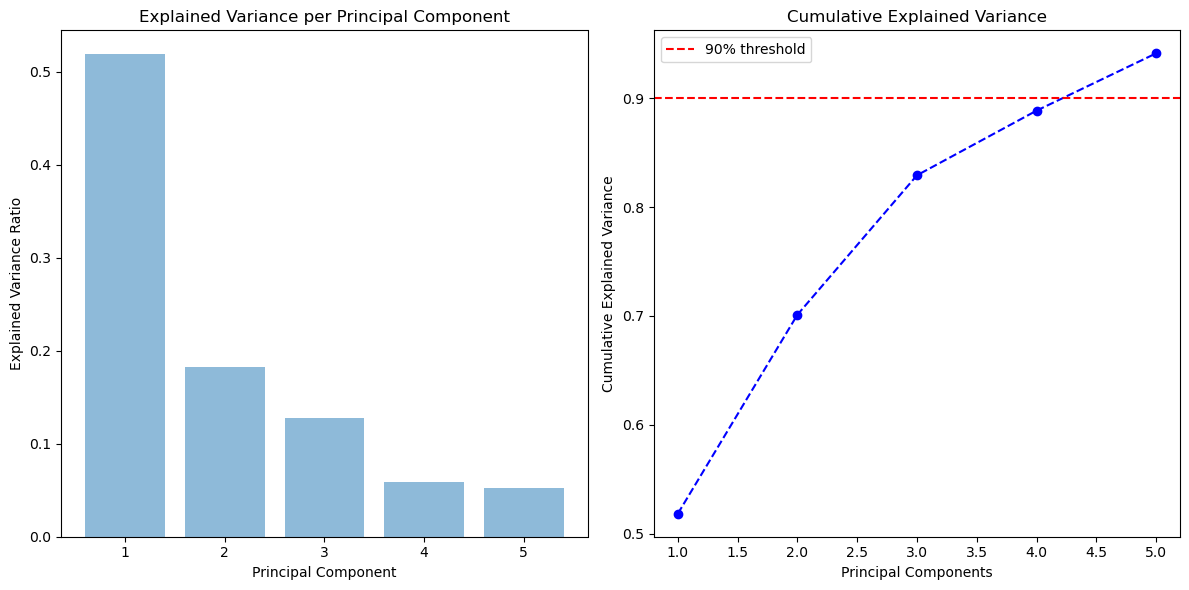

        Date  indonesia_money_supply_m2  indonesia_international reserves  \
2 2024-09-30                   2.084995                          1.768896   

   indonesia_cpi  indonesia_10y_yield   USD/IDR  indonesia_equity_index_JKSE  
2      -1.282572            -0.446925  1.007036                     1.772418  


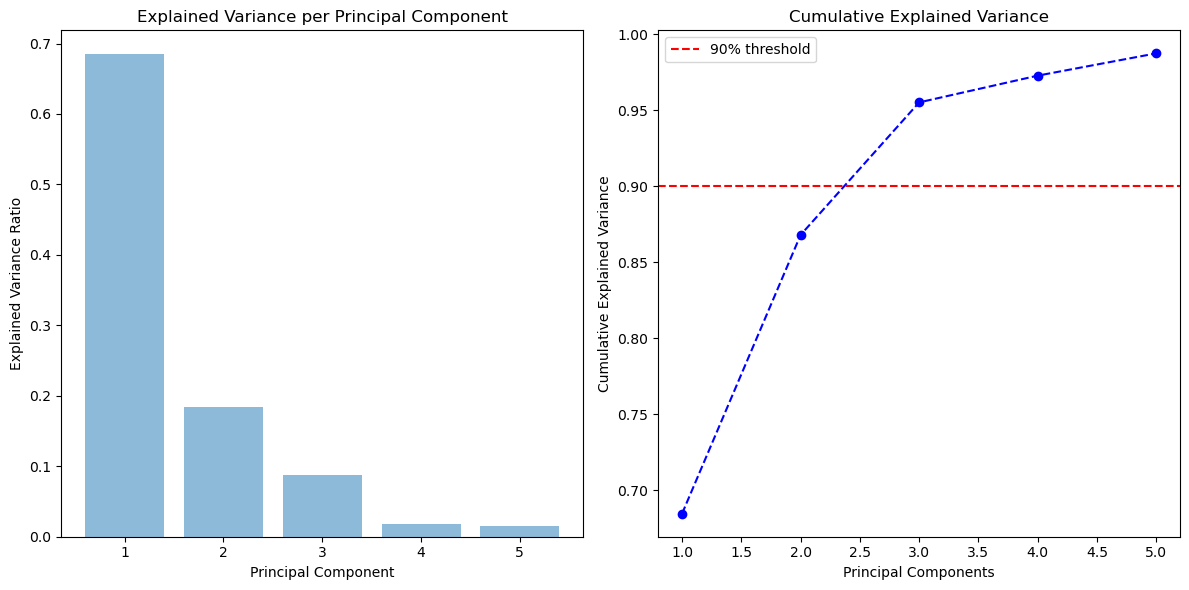

        Date  italy_cpi  italy_ppi  italy_consumer_confidence_index  \
2 2024-09-30  -0.480793  -0.480107                         0.670193   

   italy_current_account_balance  italy_money_supply_m2  \
2                      -0.067968               1.425193   

   italy_international_reserves  italy_10y_yield  italy_equity_index   USD/EUR  
2                      2.190766         0.310239            2.833445  0.660171  


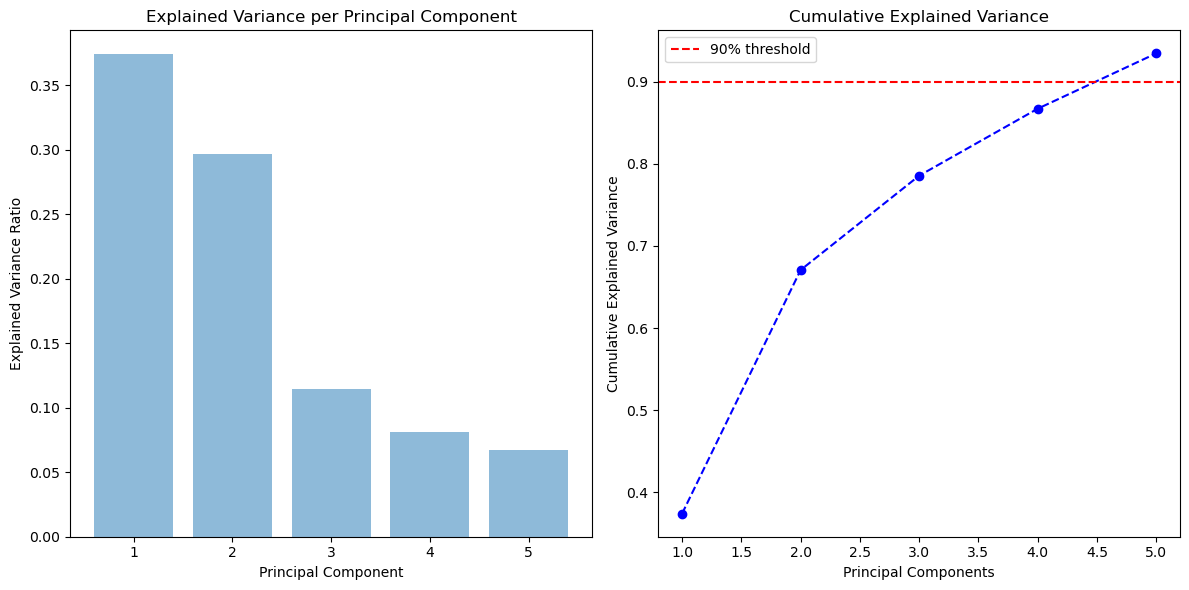

        Date  egypt_cpi_yoy  egypt_10y_yield  \
3 2024-09-30       1.382174          2.36639   

   egypt_net_international_reserves   egypt_money_supply_m2   EGP/USD  \
3                           1.483125               0.011452  3.398497   

   egypt_equity_index_EGX30  
3                  3.526299  


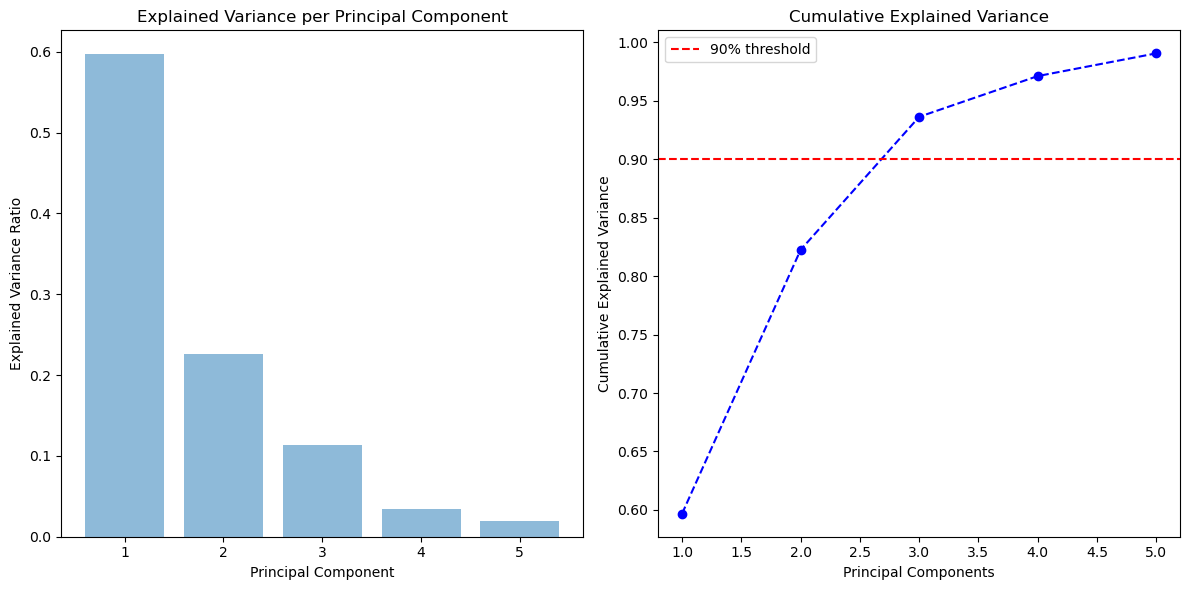

In [10]:
from sklearn.decomposition import PCA
#

#fit PCA to the whole dataset
def fit_visualize_pca(df, components):
    
    # Initialize PCA
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    features_reduced = df[num_cols]
    
    pca = PCA(n_components=components)  # Keeping all components to analyze explained variance
    
    # Fit PCA on the scaled data
    pca.fit(features_reduced)
    
    # Transform the data using PCA
    features_pca = pca.transform(features_reduced)
    
    # Explained variance by each component
    explained_variance = pca.explained_variance_ratio_
    
    # Cumulative explained variance
    cumulative_variance = np.cumsum(explained_variance)

    print(df.head(1))
    # Plot explained variance and cumulative explained variance
    plt.figure(figsize=(12, 6))
    
    # Individual explained variance
    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual Explained Variance')
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Principal Component')
    plt.title('Explained Variance per Principal Component')
    
    # Cumulative explained variance
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
    plt.ylabel('Cumulative Explained Variance')
    plt.xlabel('Principal Components')
    plt.title('Cumulative Explained Variance')
    plt.axhline(y=0.90, color='r', linestyle='--', label='90% threshold')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    loadings = pca.components_.T
    return loadings, features_reduced

#put loadings into a list
loadings_list = []
for country,df in st_country_dict.items():
    loadings = fit_visualize_pca(df,5)
    loadings_list.append(loadings)

In [11]:
# List loadings for the first 2 PCs for each country
for loadings, features_reduced in loadings_list:
    selected_loadings = loadings[[1,2]]
    loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=features_reduced.columns)
    selected_PC = ['PC1', 'PC2']
    print(loadings_df[selected_PC].sort_values(by = 'PC1',key = abs, ascending = False))

                                            PC1       PC2
china_10y_yield                       -0.504722  0.003668
china_money_supply_m2                  0.490018 -0.100234
CNY/USD                                0.426778  0.187443
china_cpi                             -0.342740  0.266786
china_equity_shanghai_composite_index  0.336705  0.198991
china_gdp                             -0.216988  0.163162
china_fx_reserves                     -0.175985 -0.576296
china_consumer_confidence_index       -0.107458  0.383411
china_ppi                             -0.050560  0.581627
                                            PC1       PC2
USD/TRY                                0.441466 -0.162636
turkey_cpi                             0.431013 -0.114436
turkey_10y_yield                       0.417124  0.015199
turkey_equity_index                    0.401378 -0.274387
turkey_ppi                             0.346515  0.023916
turkey_international_reserves_ex_gold -0.249735 -0.407528
turkey_consume

Create dataframe with every feature of each country to analyze how PCA explains the variance of the overall dataset.

In [13]:
#Create a dataframe for the entire dataset
aggregate_df = pd.DataFrame()


for country, df in st_country_dict.items():
    temp_df = df.set_index('Date')        # Set 'Date' as index
    aggregate_df = pd.concat([aggregate_df,temp_df], axis = 1)

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2024-09-30                        -1.789503               1.938862  1.177962   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2024-09-30           0.284766  -0.852344   -1.22258  -0.403351   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2024-09-30                               0.846913        -2.079142   

            turkey_10y_yield  ...  italy_international_reserves  \
Date                          ...                                 
2024-09-30          2.801113  ...                      2.190766   

            italy_10y_yield  italy_equity_index   USD/EUR  egypt_cpi_yoy  \
Date                                                                   

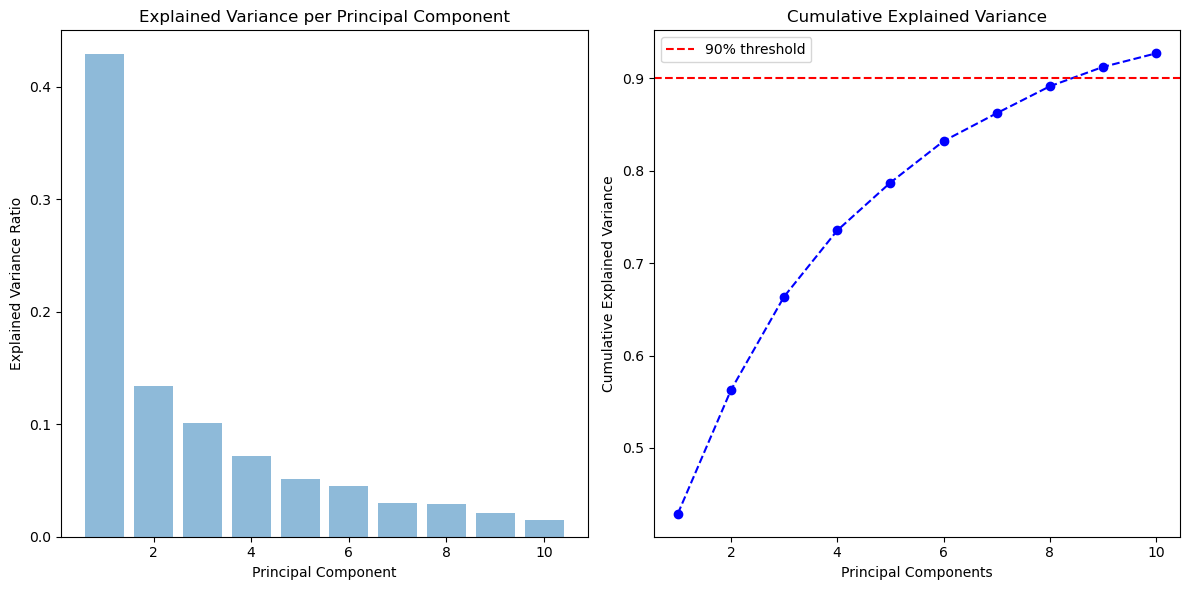

In [14]:
#Fit and visualize PCA for the entire dataset
aggregate_loadings, features_reduced = fit_visualize_pca(aggregate_df,10)

In [15]:
#List loadings loadings for the first 2 PCs of the whole dataset
selected_loadings = aggregate_loadings[[1,2]]
loadings_df = pd.DataFrame(aggregate_loadings, columns=[f'PC{i+1}' for i in range(aggregate_loadings.shape[1])], index=features_reduced.columns)
selected_PC = ['PC1', 'PC2']
print(loadings_df[selected_PC].sort_values(by = 'PC1',key = abs, ascending = False).head(7))

                                   PC1       PC2
china_money_supply_m2         0.237805  0.037492
indonesia_money_supply_m2     0.235448 -0.008383
EGP/USD                       0.222271 -0.065471
USD/TRY                       0.222194 -0.153871
indonesia_equity_index_JKSE   0.218408  0.034405
italy_international_reserves  0.214709 -0.134872
USD/IDR                       0.209608  0.140878


I checked PCA for individual countries, there money supply was one of the greatest driver of variance. Then I ran PCA for the overall dataset where the first 9 components explain over 90 percent of variance. The first PC’s largest loading is china’s money supply, then Indonesia money supply,  fx rates of EGP/USD and USD/TRY. I think fx rates and money supply can explain a lot about the purchasing power of an importing country which can be a driver of international wheat prices.

### Analyze how Principal components are changing each year

To see how PCA composition changes each year I will use a rolling 5-year window

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2010-01-31                        -0.198508              -1.638432  0.615234   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2010-01-31          -2.657575   0.732418  -0.458419   1.782484   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2010-01-31                               0.135525         0.518329   

            turkey_10y_yield  ...  italy_10y_yield  italy_equity_index  \
Date                          ...                                        
2010-01-31         -0.241155  ...         0.738903            0.078403   

             USD/EUR  egypt_cpi_yoy  egypt_10y_yield  \
Date                                                   
2010-01-31 -1.

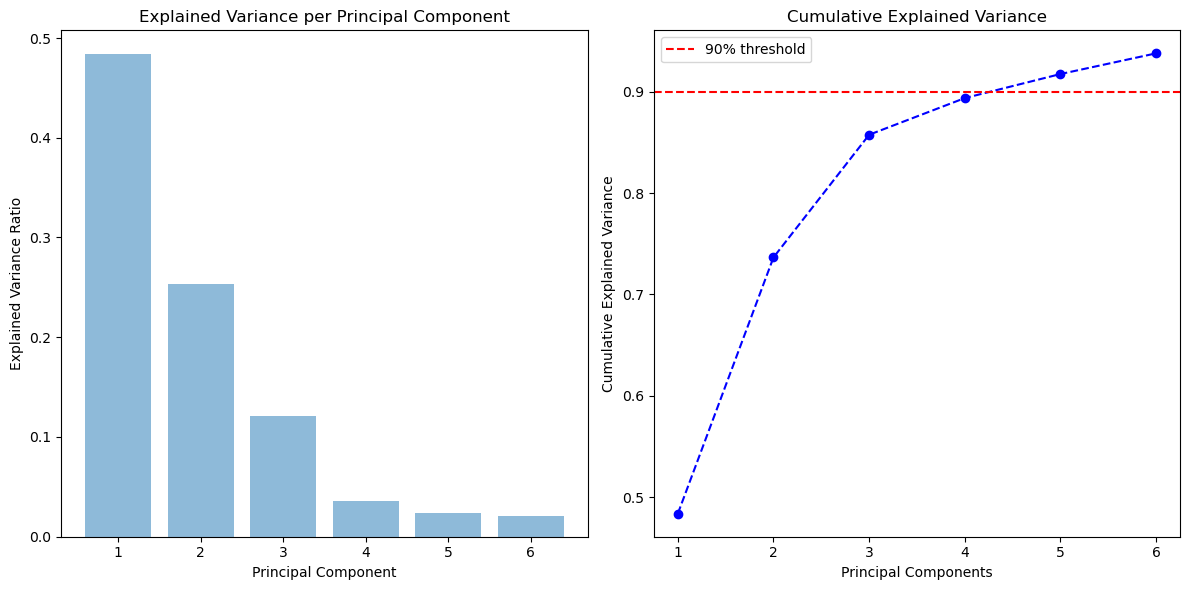

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2011-12-31                        -0.550201               -1.19148 -0.945618   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2011-12-31          -0.156904   0.152083   1.347782   0.750885   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2011-12-31                              -1.482848         0.270041   

            turkey_10y_yield  ...  italy_10y_yield  italy_equity_index  \
Date                          ...                                        
2011-12-31         -0.520369  ...         2.620119           -1.455032   

             USD/EUR  egypt_cpi_yoy  egypt_10y_yield  \
Date                                                   
2011-12-31 -0.

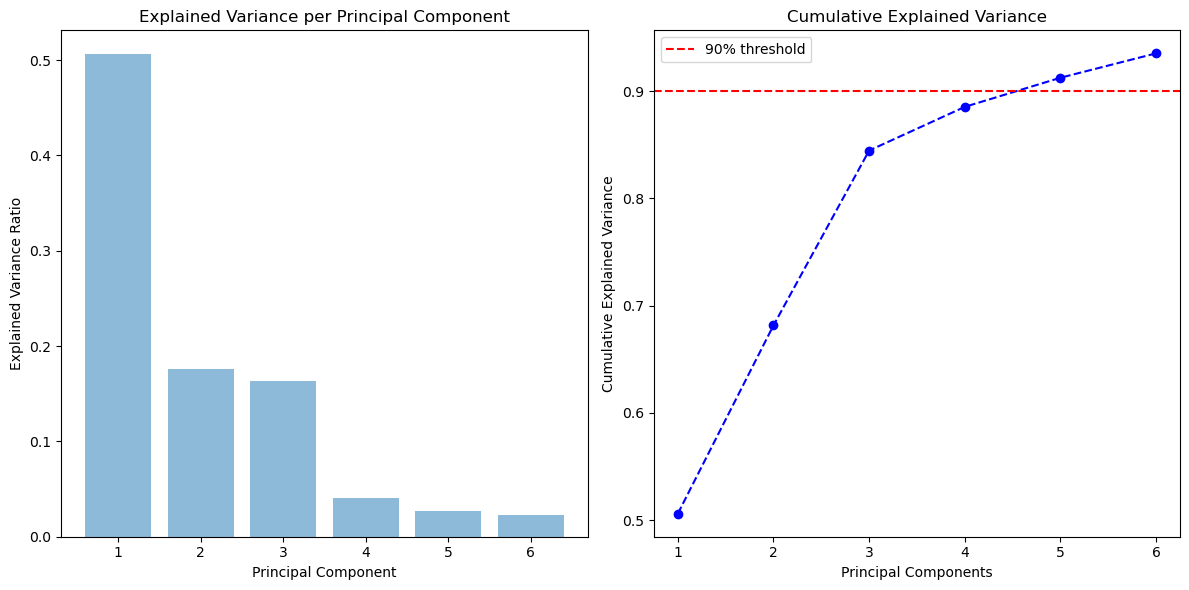

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2012-12-31                        -0.282244              -0.975708 -1.135149   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2012-12-31           0.263967  -0.651459   0.236274   0.343296   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2012-12-31                              -1.340017         0.556527   

            turkey_10y_yield  ...  italy_10y_yield  italy_equity_index  \
Date                          ...                                        
2012-12-31         -0.555271  ...          0.98035           -1.188372   

             USD/EUR  egypt_cpi_yoy  egypt_10y_yield  \
Date                                                   
2012-12-31 -1.

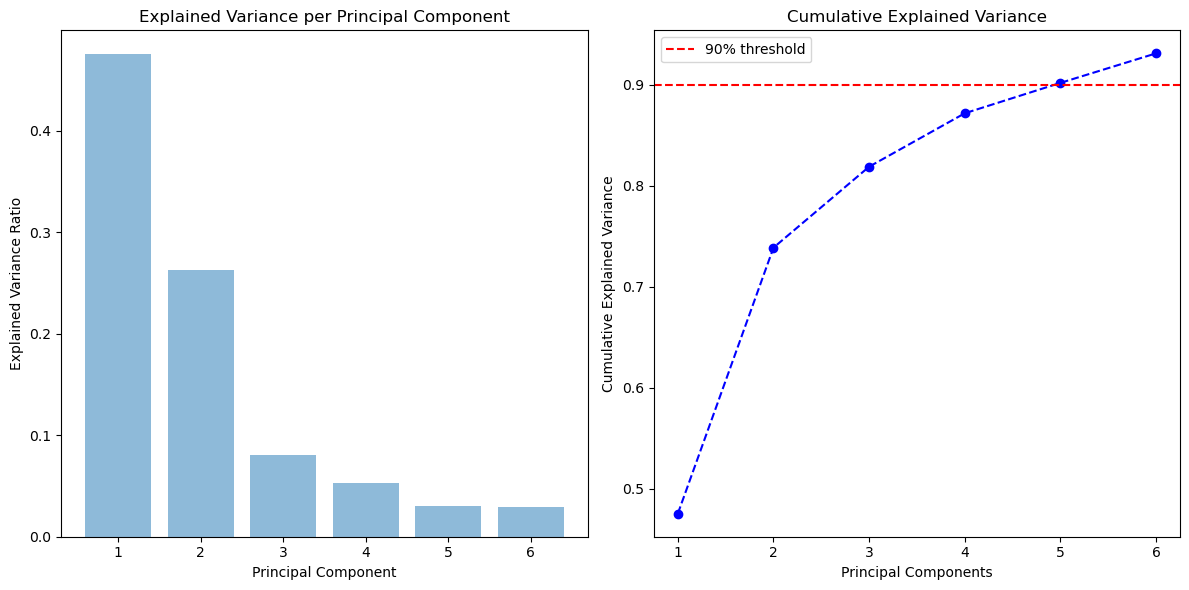

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2013-08-31                         -0.77629              -0.801089 -1.458762   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2013-08-31           1.057516  -0.584497   0.305743   0.227872   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2013-08-31                              -1.689859         1.415984   

            turkey_10y_yield  ...  italy_10y_yield  italy_equity_index  \
Date                          ...                                        
2013-08-31         -0.473833  ...         0.921602           -1.096268   

             USD/EUR  egypt_cpi_yoy  egypt_10y_yield  \
Date                                                   
2013-08-31 -1.

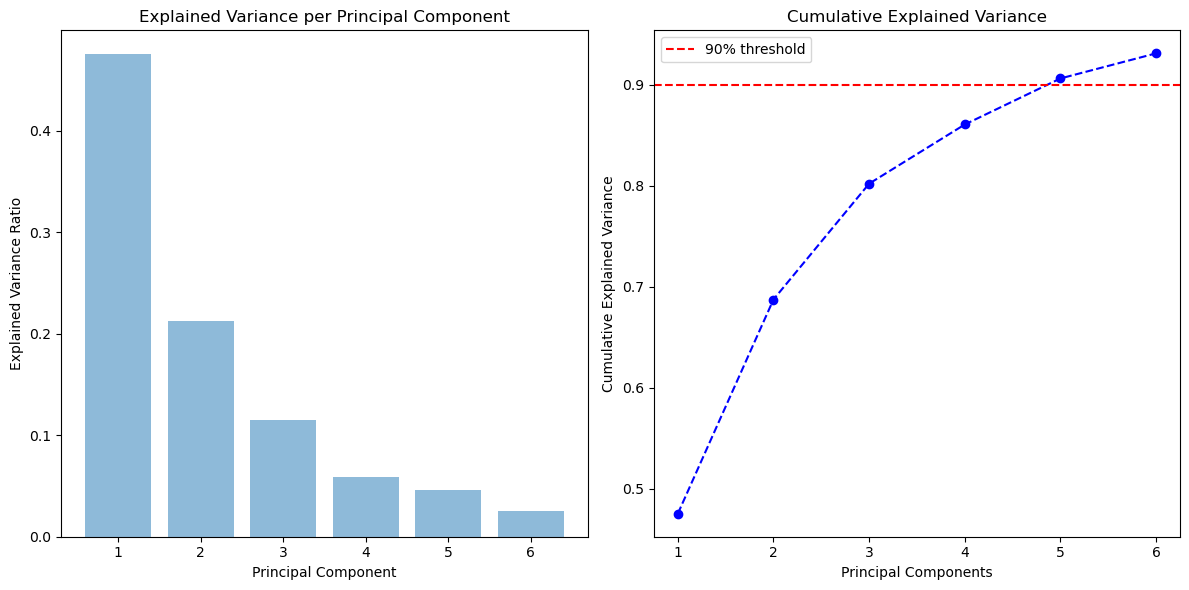

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2014-12-31                        -0.106397              -0.549663 -1.207324   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2014-12-31           1.994468  -0.963947  -0.458419   0.076378   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2014-12-31                               0.638296         0.671121   

            turkey_10y_yield  ...  italy_10y_yield  italy_equity_index  \
Date                          ...                                        
2014-12-31          -0.99542  ...        -0.705902           -0.571403   

             USD/EUR  egypt_cpi_yoy  egypt_10y_yield  \
Date                                                   
2014-12-31 -0.

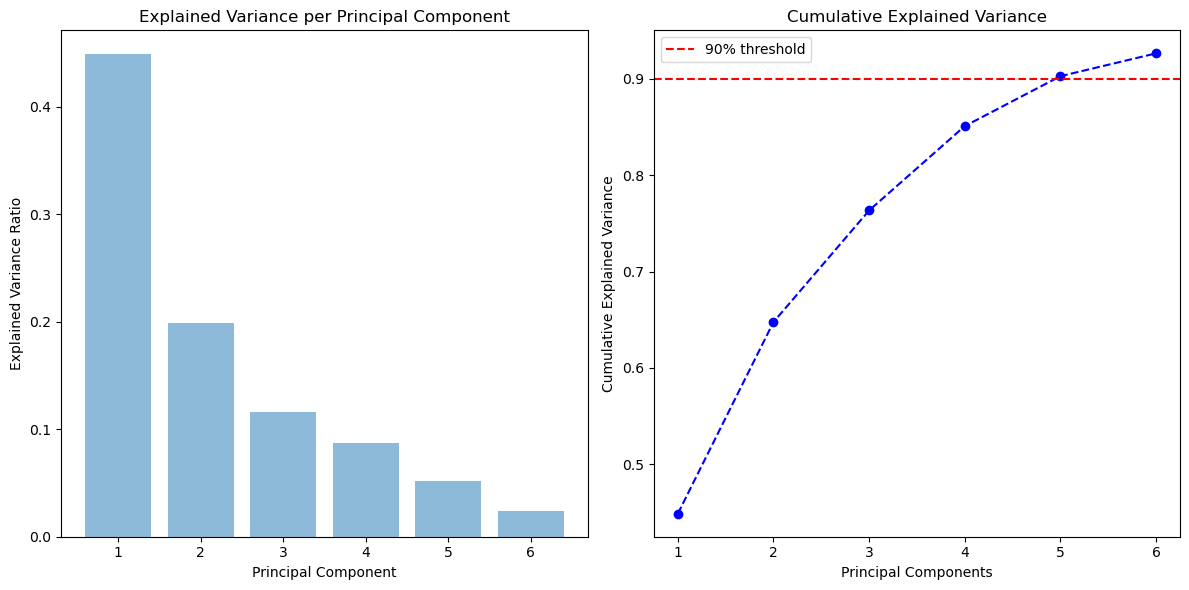

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2015-11-30                         -0.24875              -0.377762 -0.641956   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2015-11-30           0.682879  -1.544282  -0.458419  -0.013796   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2015-11-30                               1.070054        -0.335399   

            turkey_10y_yield  ...  italy_10y_yield  italy_equity_index  \
Date                          ...                                        
2015-11-30         -0.375914  ...        -1.002868             0.26352   

             USD/EUR  egypt_cpi_yoy  egypt_10y_yield  \
Date                                                   
2015-11-30  1.

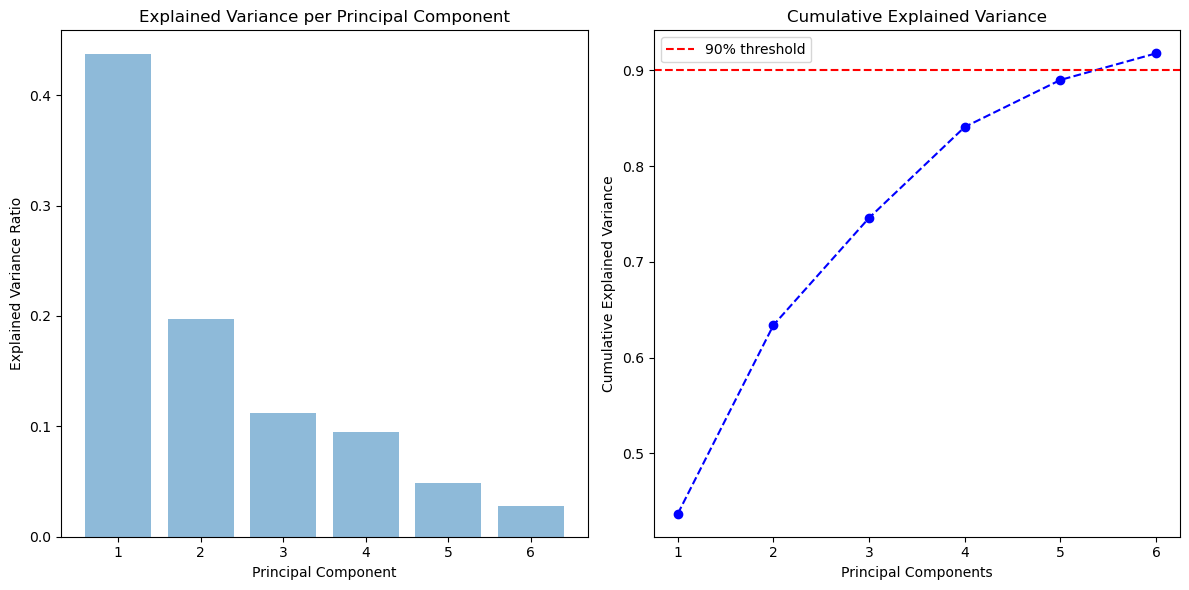

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2016-12-31                         0.111318              -0.291146  0.961731   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2016-12-31          -0.713874   1.000265  -0.041603  -0.024617   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2016-12-31                               0.369807        -0.455723   

            turkey_10y_yield  ...  italy_10y_yield  italy_equity_index  \
Date                          ...                                        
2016-12-31         -0.754017  ...        -0.747865           -0.521249   

             USD/EUR  egypt_cpi_yoy  egypt_10y_yield  \
Date                                                   
2016-12-31  1.

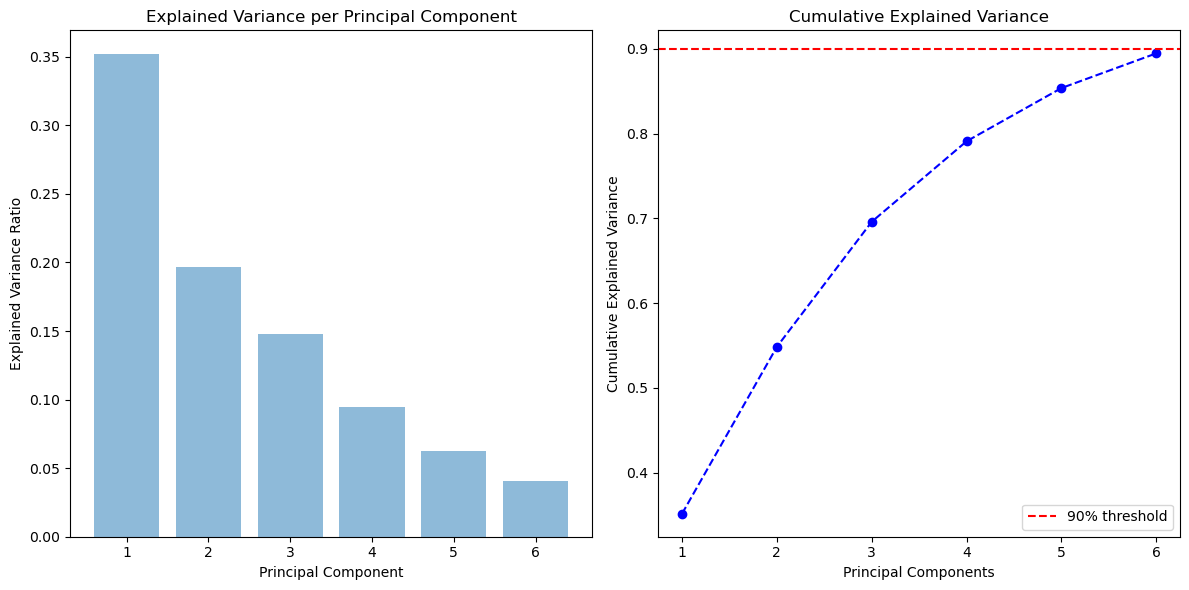

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2017-01-31                         0.178307               -0.23239  0.782761   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2017-01-31          -0.754077   1.312753   0.236274  -0.107578   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2017-01-31                                0.48358         0.126798   

            turkey_10y_yield  ...  italy_10y_yield  italy_equity_index  \
Date                          ...                                        
2017-01-31         -0.586294  ...        -0.463164           -0.666301   

             USD/EUR  egypt_cpi_yoy  egypt_10y_yield  \
Date                                                   
2017-01-31  1.

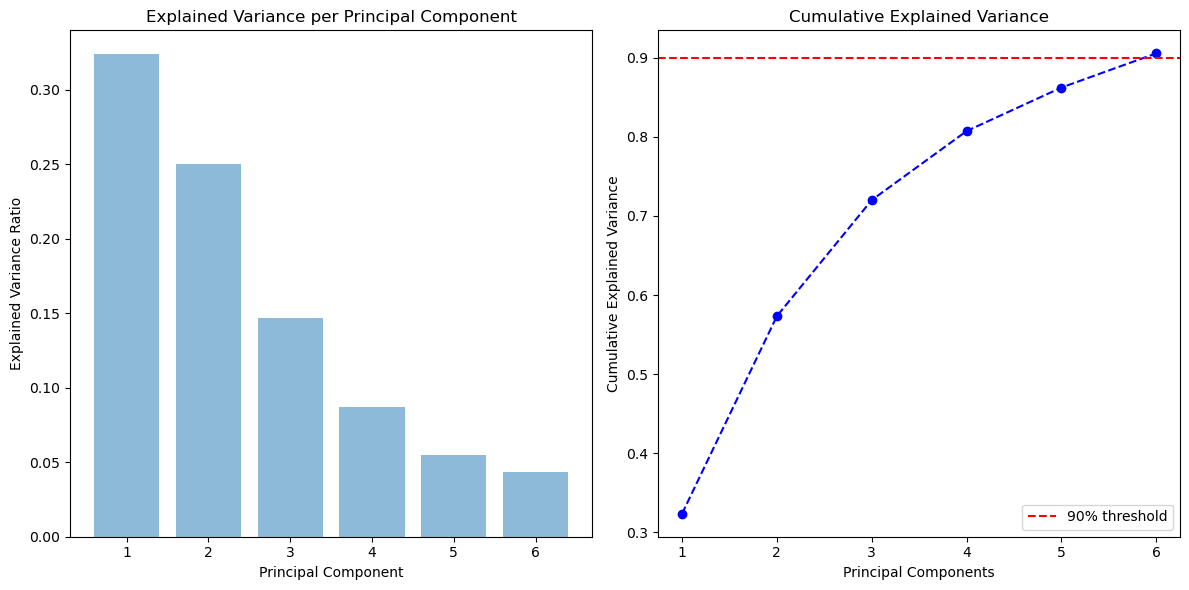

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2018-12-31                         1.333872               0.142898  0.766625   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2018-12-31          -0.510807  -0.026482  -0.180542  -0.168897   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2018-12-31                              -0.879491         0.021753   

            turkey_10y_yield  ...  italy_10y_yield  italy_equity_index  \
Date                          ...                                        
2018-12-31         -0.292538  ...        -0.149413           -0.726385   

             USD/EUR  egypt_cpi_yoy  egypt_10y_yield  \
Date                                                   
2018-12-31  0.

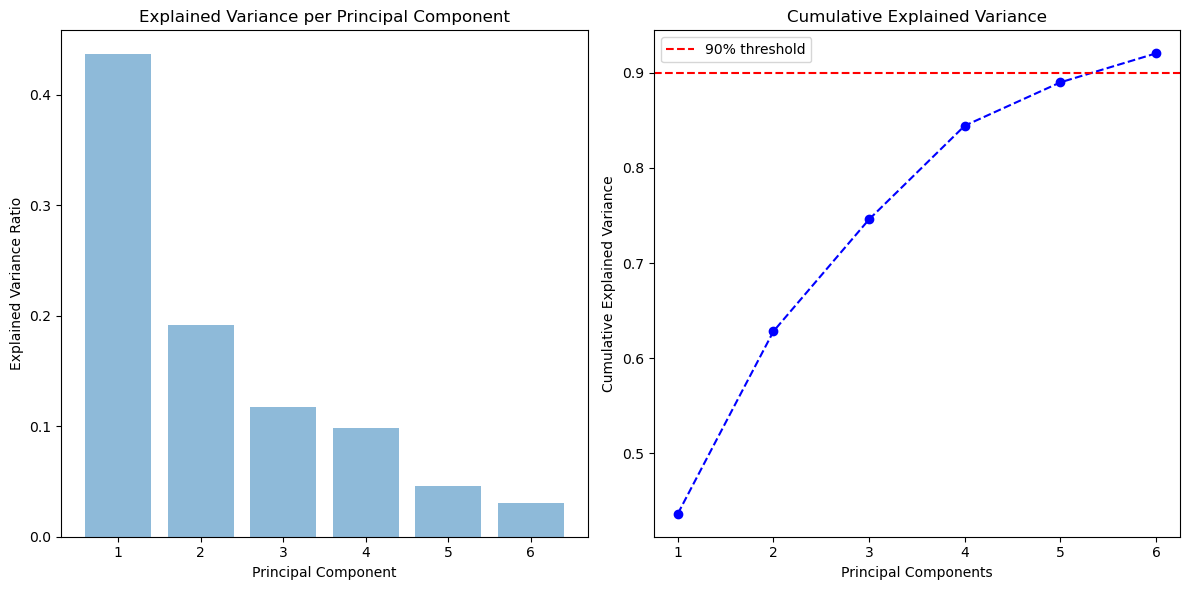

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2019-09-30                         1.425982               0.220056  1.558199   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2019-09-30          -0.446416  -0.495214    0.58362  -0.179718   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2019-09-30                              -0.036793         -0.30102   

            turkey_10y_yield  ...  italy_10y_yield  italy_equity_index  \
Date                          ...                                        
2019-09-30         -0.156809  ...        -1.388279            0.126031   

             USD/EUR  egypt_cpi_yoy  egypt_10y_yield  \
Date                                                   
2019-09-30  0.

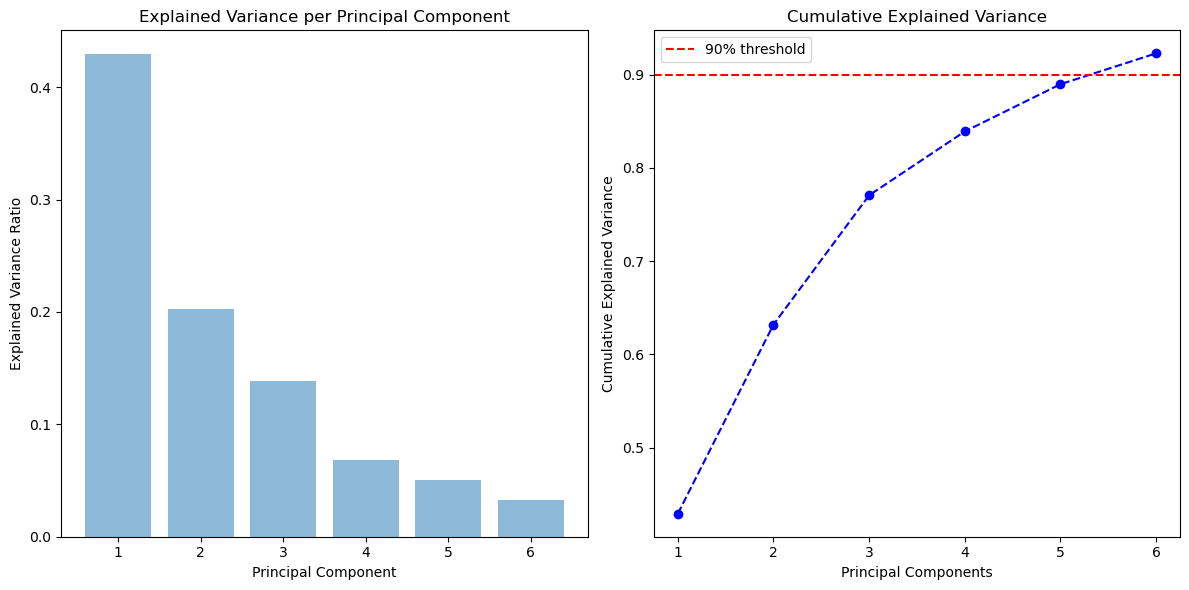

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2020-12-31                         1.258509               0.854216 -0.264065   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2020-12-31          -0.041254   -0.31665  -1.361519  -0.035438   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2020-12-31                               1.126735        -0.291471   

            turkey_10y_yield  ...  italy_10y_yield  italy_equity_index  \
Date                          ...                                        
2020-12-31         -0.043378  ...        -1.568395            0.154237   

            USD/EUR  egypt_cpi_yoy  egypt_10y_yield  \
Date                                                  
2020-12-31 -0.35

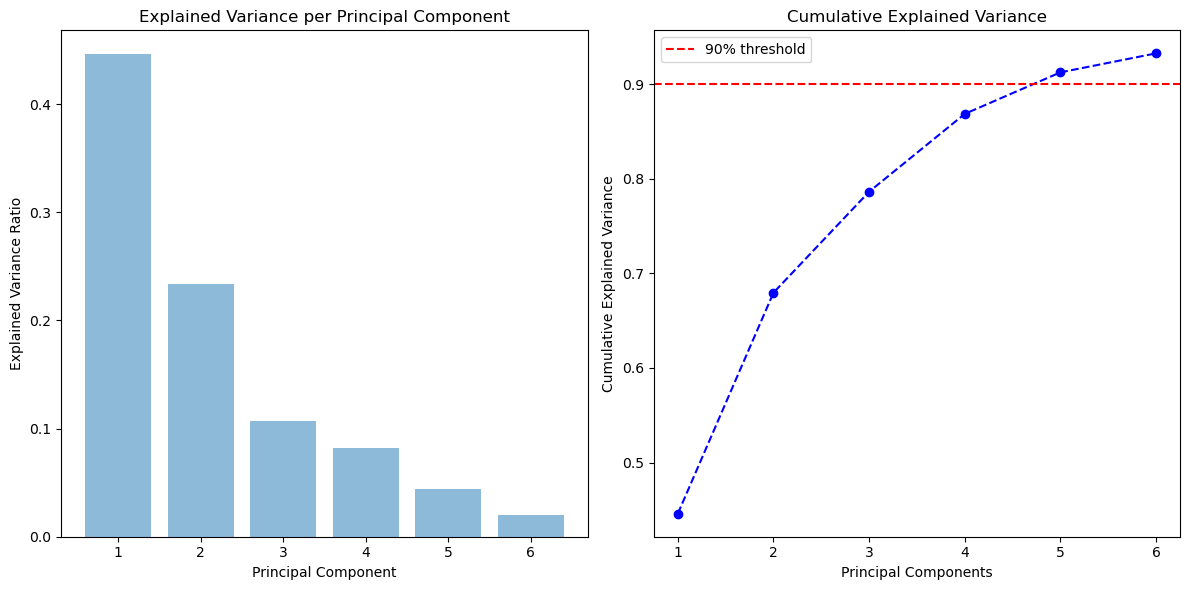

In [18]:


#fixes 5 yearly PCA
aggregate_df['Year'] = aggregate_df.index.year

# Sort the data by year to ensure proper grouping
aggregate_df_sorted = aggregate_df.sort_values(by='Year')

# Get unique years for rolling 5-year windows
unique_years = aggregate_df_sorted['Year'].unique()

# Initialize a dictionary to store PCA results
pca_results = {}

# Loop over each 5-year rolling window
for i in range(len(unique_years) - 4):
    #5 yr window
    window_years = unique_years[i:i+5]
    
    # Filter the data for the current 5-year window
    five_year_data = aggregate_df_sorted[aggregate_df_sorted['Year'].isin(window_years)]

    # Apply PCA on the 5-year data for the first 6 PCs
    loadings = fit_visualize_pca(five_year_data, 6)
    
    # Store the PCA results with the last year of the window as the key
    pca_results[window_years[-1]] = loadings

In [19]:
# Iterate over rolling windows in pca_results
for year, (loadings, features_reduced) in pca_results.items():
    print(f"\nRolling window: {year-4}-{year}")
    
    # Select the first and second principal component loadings
    selected_loadings = loadings[:, [0, 1]]  # PC1 and PC2
    
    # Create a DataFrame for PC1 and PC2 loadings
    loadings_df = pd.DataFrame(
        selected_loadings,
        columns=[f'PC{i+1}' for i in range(selected_loadings.shape[1])],
        index=features_reduced.columns
    )
    
    # Sort by absolute values of PC1 and display the top 4 features
    print("\nTop 4 features sorted by PC1 absolute loadings:")
    print(loadings_df[['PC1', 'PC2']].sort_values(by='PC1', key=lambda x: x.abs(), ascending=False).head(4))



Rolling window: 2010-2014

Top 4 features sorted by PC1 absolute loadings:
                                            PC1       PC2
china_fx_reserves                     -0.524507 -0.051324
turkey_money_supply_m2                -0.339320 -0.121025
italy_current_account_balance         -0.275103 -0.020906
turkey_international_reserves_ex_gold -0.265666 -0.082464

Rolling window: 2011-2015

Top 4 features sorted by PC1 absolute loadings:
                          PC1       PC2
italy_10y_yield     -0.343302 -0.046049
indonesia_10y_yield  0.337467  0.304265
china_cpi           -0.267949  0.329112
USD/IDR              0.263294 -0.004589

Rolling window: 2012-2016

Top 4 features sorted by PC1 absolute loadings:
                                            PC1       PC2
china_equity_shanghai_composite_index -0.410330 -0.142861
italy_consumer_confidence_index       -0.409998 -0.008032
italy_10y_yield                        0.368946 -0.012614
indonesia_10y_yield                   -0.327770  0

In [20]:
first_loadings = {}
# Iterate over rolling windows in pca_results
for year, (loadings, features_reduced) in pca_results.items():

    # Select the first and second principal component loadings
    selected_loadings = loadings[:, [0, 1]]  # PC1 and PC2
    
    # Create a DataFrame for PC1 and PC2 loadings
    loadings_df = pd.DataFrame(
        selected_loadings,
        columns=[f'PC{i+1}' for i in range(selected_loadings.shape[1])],
        index=features_reduced.columns
    )
    # Sort by absolute values of PC1 and display the top 4 features
    
    first_loadings[year] = loadings_df[['PC1']].sort_values(by='PC1', key=lambda x: x.abs(), ascending=False).head(1)

print(first_loadings.items())

dict_items([(2014,                         PC1
china_fx_reserves -0.524507), (2015,                       PC1
italy_10y_yield -0.343302), (2016,                                            PC1
china_equity_shanghai_composite_index -0.41033), (2017,                                             PC1
china_equity_shanghai_composite_index -0.353478), (2018,                         PC1
china_fx_reserves  0.407465), (2019,                                         PC1
egypt_net_international_reserves  -0.427354), (2020,                                      PC1
turkey_consumer_confidence_index -0.4247), (2021,                             PC1
egypt_money_supply_m2  0.447273), (2022,                 PC1
italy_ppi  0.403416), (2023,                 PC1
italy_cpi  0.346623), (2024,                       PC1
egypt_10y_yield  0.344686)])


I fit PCA to a 5 year rolling window in order to analyze the changing composition of features that explain the most variance in data. Based on the loadings of the first PC. The results do not point to a single direction. Out of the 11 windows analyzed in 4 a feature associated with china was the main driver of variance (largest absolute loading of the first principal component for the 5 year window). Italy and egypt had largest loadings for 3-3 years and turkey for 1. 

Fitting PCA for the 5 year rolling window resulted in fewer principal component explaining 90 percent of the variance. I can think of 2 factors contributing to this:
1. There are different global processes for each 5 year-window that determine the variance in these features
2. There are fewer datapoints for the 5 year window so fewer feature can explain a larger amount of variance


If one reasons from an economic perspective, it seems intuitive that china is driver of variance since it poses the greatest global demand which can determine economic and financial condition for other countries. 

In the case of italy, cpi and ppi (consumer price index and producer price index) refers to the price for a basket of good for a consumer or a producer. Given the large amount of grain imports in italy, grain prices are probably the cause of higher domestic prices in italy which in turn drives up consumer and producer prices.



### 3. Analyze correlations

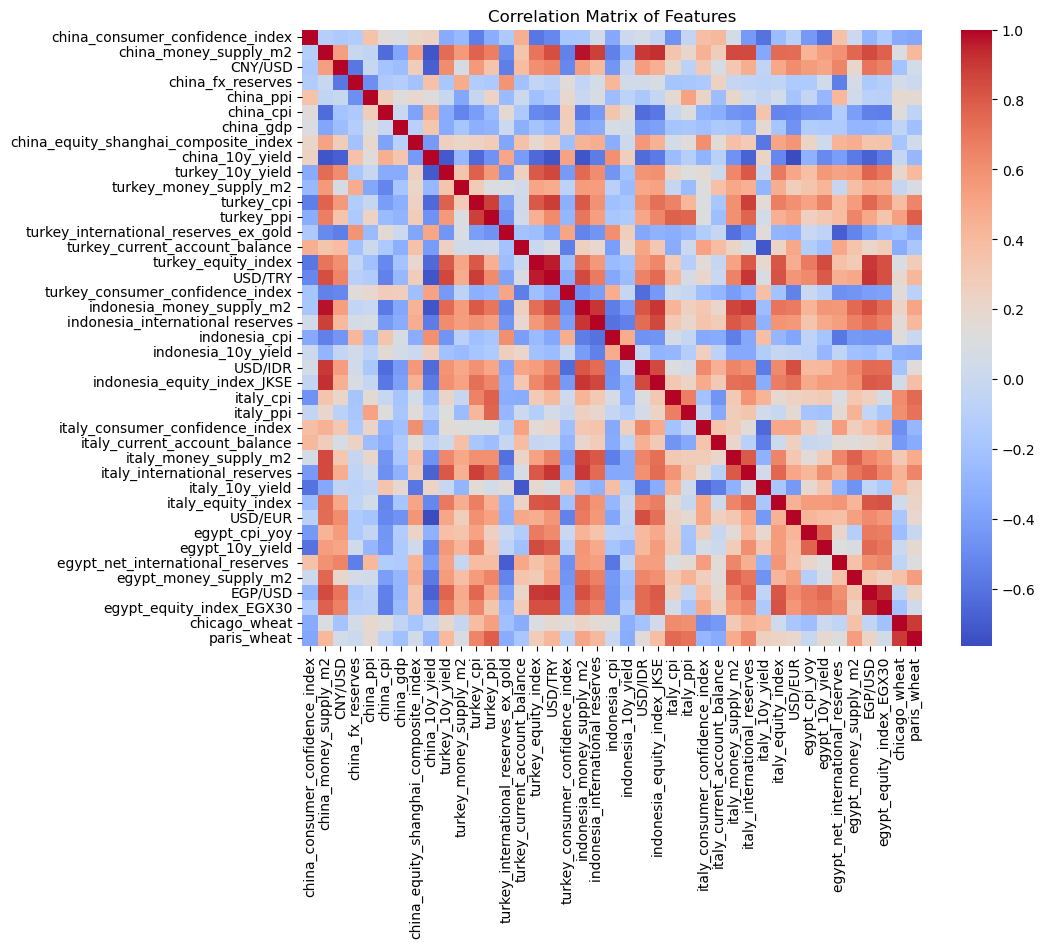

In [23]:
aggregate_df = aggregate_df.drop('Year',axis=1)
#visualize correlations

correlation_df = pd.concat([aggregate_df,wheat_price[['chicago_wheat','paris_wheat']]], axis = 1)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df.corr(), cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

In [24]:
#list correlations with chicago wheat
correlations = correlation_df.corr()['chicago_wheat'].sort_values(ascending=False)
print(correlations.head(10))  # Display top correlations with SalePrice

chicago_wheat                   1.000000
paris_wheat                     0.891402
italy_cpi                       0.616667
italy_ppi                       0.604430
turkey_ppi                      0.527677
italy_international_reserves    0.440403
italy_10y_yield                 0.411478
turkey_cpi                      0.381132
egypt_money_supply_m2           0.356717
italy_money_supply_m2           0.310805
Name: chicago_wheat, dtype: float64


In [25]:
#list correlations with paris wheat

correlations = correlation_df.corr()['paris_wheat'].sort_values(ascending=False)
print(correlations.head(10))  # Display top correlations with SalePrice

paris_wheat                     1.000000
chicago_wheat                   0.891402
turkey_ppi                      0.781126
italy_cpi                       0.747556
italy_ppi                       0.714690
italy_international_reserves    0.646802
turkey_cpi                      0.646343
egypt_money_supply_m2           0.541878
indonesia_money_supply_m2       0.505894
italy_money_supply_m2           0.473737
Name: paris_wheat, dtype: float64


Analyzing the correlation matrix for pairwise correlations. From the visualization the most interesting part is the bottom 2 rows that represent the 2 target features; the chicago and paris wheat price and how they correlate with other features.

There are few strong correlations (dark red or dark blue). The strongest correlation is with the cpi and ppi index of turkey and italy.
This is probably due to the fact that higher grain prices cause higher consumer prices and producer prices as I briefly mentioned before.

Of course correlation does not mean causality, but it is important to keep in mind that probably the grain prices are driving the ppi and cpi, not the other way around. This seems trivial for a grain importing country as the price of bread and other products rise with higher imported grain prices.

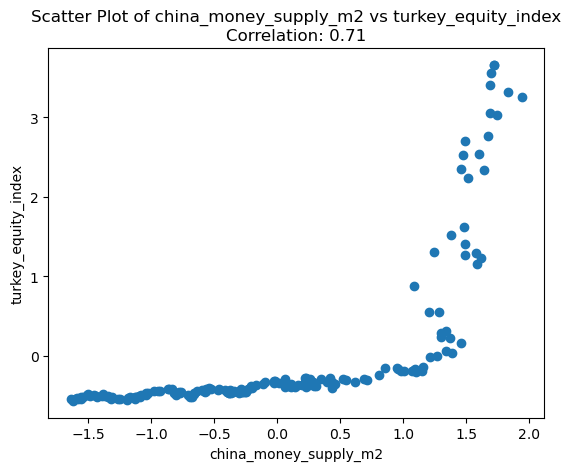

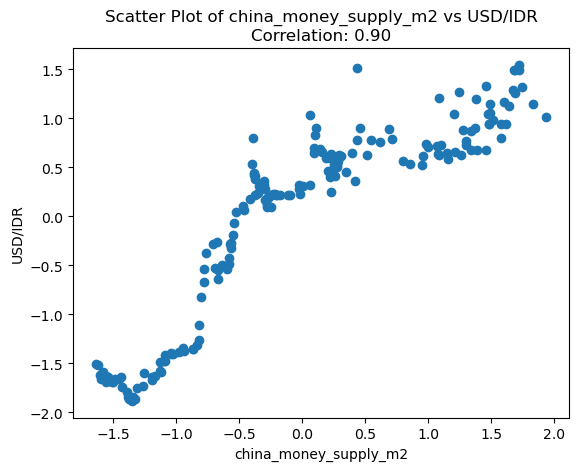

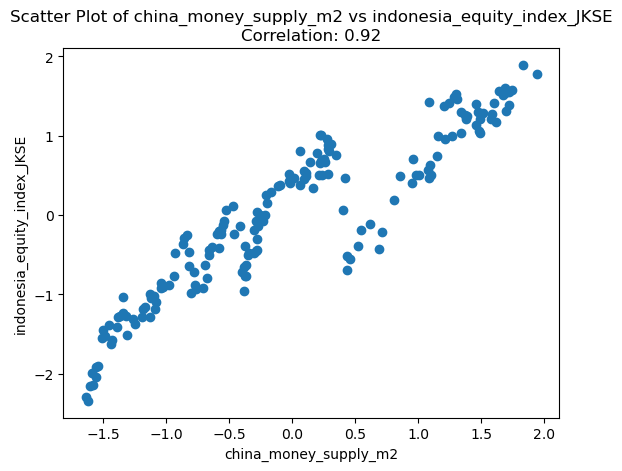

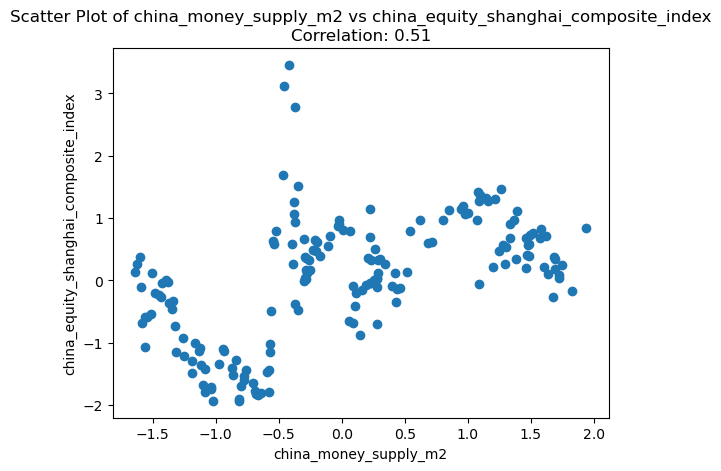

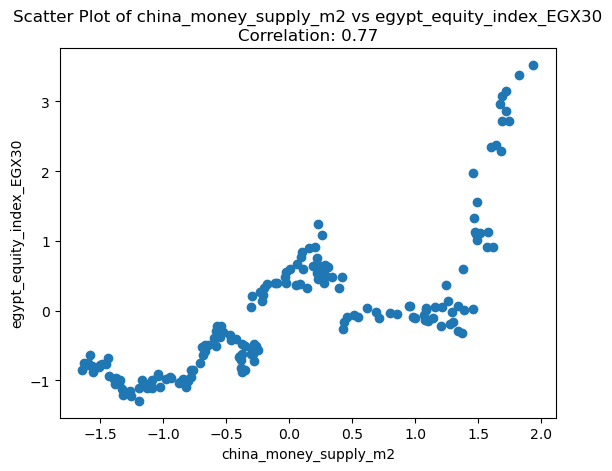

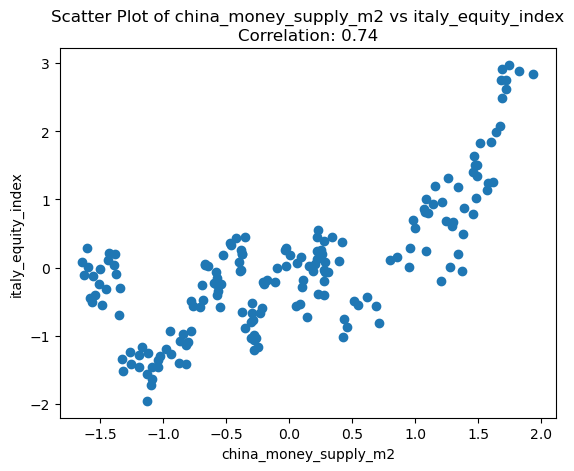

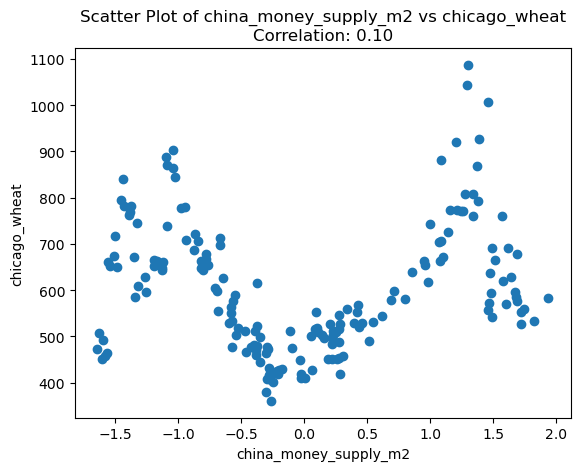

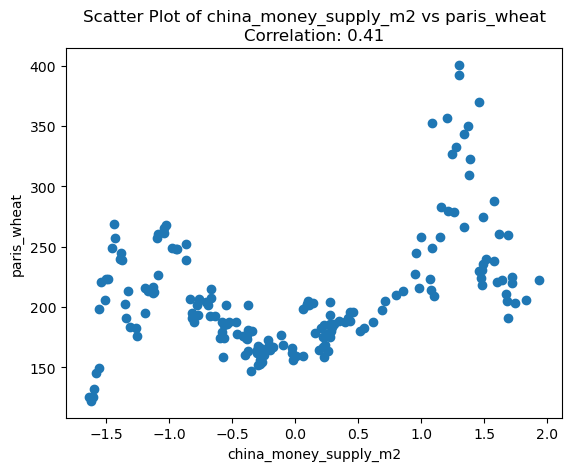

In [27]:
### Pairwise correlations
import matplotlib.pyplot as plt

def visualize_corr(df,feature1,feature2):
    
    correlation = df[feature1].corr(df[feature2])
    # Assuming df is your DataFrame and 'feature1' and 'feature2' are the column names
    plt.scatter(df[feature1], df[feature2])
    plt.title(f'Scatter Plot of {feature1} vs {feature2}\nCorrelation: {correlation:.2f}')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()

visualize_corr(correlation_df, 'china_money_supply_m2','turkey_equity_index')
visualize_corr(correlation_df, 'china_money_supply_m2','USD/IDR')
visualize_corr(correlation_df, 'china_money_supply_m2','indonesia_equity_index_JKSE')
visualize_corr(correlation_df, 'china_money_supply_m2','china_equity_shanghai_composite_index')
visualize_corr(correlation_df, 'china_money_supply_m2','egypt_equity_index_EGX30')
visualize_corr(correlation_df, 'china_money_supply_m2','italy_equity_index')
visualize_corr(correlation_df, 'china_money_supply_m2','chicago_wheat')
visualize_corr(correlation_df, 'china_money_supply_m2','paris_wheat')

I supsected that the chinese indicators are the main driver of variance so I visualized the correlation between chinese money supply and other features.

China’s money supply has strong -above 70 - correlations with most equity indices (except Italy). It’s correlation with wheat prices is weak – 0.11 with Chicago wheat and 0.4 with paris wheat.

Based on the visualization of the correlations there might be non-linearities between the features.
To further examine non-linearities in the data I will conduct an analysis on the polynomial combination of the features up to the 3rd degree polynomials.

I want to assess whether polynomials better explain the variance in the data.

### 4. Polynomial features

#### See how 3rd degree polynomials work with PCA

In [31]:
from sklearn.preprocessing import PolynomialFeatures

#create polynomial features
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(aggregate_df)

In [32]:
# Apply polynomial feature transformation
poly_features = poly.fit_transform(aggregate_df)

# Standardize polynomial features
scaler = StandardScaler()
poly_scaled = scaler.fit_transform(poly_features)

# Convert the result back to a DataFrame, preserve the index, and name the columns
poly_scaled_df = pd.DataFrame(poly_scaled, 
                               columns=poly.get_feature_names_out(aggregate_df.columns),
                               index=aggregate_df.index)


In [33]:
poly_scaled_df

,china_consumer_confidence_index,china_money_supply_m2,CNY/USD,china_fx_reserves,china_ppi,china_cpi,china_gdp,china_equity_shanghai_composite_index,china_10y_yield,turkey_10y_yield,...,egypt_money_supply_m2^3,egypt_money_supply_m2^2 EGP/USD,egypt_money_supply_m2^2 egypt_equity_index_EGX30,egypt_money_supply_m2 EGP/USD^2,egypt_money_supply_m2 EGP/USD egypt_equity_index_EGX30,egypt_money_supply_m2 egypt_equity_index_EGX30^2,EGP/USD^3,EGP/USD^2 egypt_equity_index_EGX30,EGP/USD egypt_equity_index_EGX30^2,egypt_equity_index_EGX30^3
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-30,-1.789503,1.938862,1.177962,0.284766,-0.852344,-1.222580,-0.403351,0.846913,-2.079142,2.801113,...,-0.254756,-0.066132,0.134505,0.265817,0.257173,0.151367,4.996643,5.824335,6.434579,6.492095
2024-08-31,-1.781129,1.828597,1.390965,0.192837,-0.629138,-1.083642,-0.655840,-0.165823,-2.140259,2.823411,...,-0.254871,-0.041017,0.158946,-0.929403,-0.787203,-0.559728,5.142302,5.692007,5.973393,5.723852
2024-07-31,-1.764382,1.721454,1.788219,0.088867,-0.405932,-1.153111,-0.489919,0.031968,-2.197556,2.774937,...,-0.255173,-0.006012,0.188938,-1.478892,-1.168499,-0.757392,5.117777,5.255899,5.117578,4.545885
2024-06-30,-1.747634,1.721481,1.907337,-0.022186,-0.405932,-1.361519,-0.489919,0.090677,-2.079142,2.829228,...,-0.255468,0.018782,0.205603,-1.733430,-1.262883,-0.752100,4.889424,4.629404,4.152931,3.391752
2024-05-31,-1.730887,1.691851,1.832522,0.009417,-0.539856,-1.292049,-0.349246,0.335336,-1.870962,2.748760,...,-0.255948,0.050993,0.229927,-1.974162,-1.400401,-0.808181,4.529267,4.165101,3.626567,2.870277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-05-31,0.077823,-1.581944,0.617874,-2.578266,1.357394,0.653089,1.194545,-0.678184,-0.131039,-0.324531,...,-0.770181,-1.941606,-1.143575,-1.113683,-0.629467,-0.302966,-0.318397,-0.292421,-0.272662,-0.256448
2010-04-30,-0.039408,-1.591769,0.610539,-2.411746,1.290433,0.444682,1.511960,-0.107640,0.212744,-0.330348,...,-0.730592,-1.864207,-1.290236,-1.108338,-0.745906,-0.423778,-0.321866,-0.308365,-0.295648,-0.280704
2010-03-31,0.069449,-1.601779,0.612300,-2.553810,1.089547,0.166805,1.641811,0.381010,0.327338,-0.361372,...,-0.707842,-1.816702,-1.299883,-1.102805,-0.771021,-0.454073,-0.323748,-0.313340,-0.302785,-0.288615


            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2024-09-30                        -1.789503               1.938862  1.177962   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2024-09-30           0.284766  -0.852344   -1.22258  -0.403351   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2024-09-30                               0.846913        -2.079142   

            turkey_10y_yield  ...  egypt_money_supply_m2^3  \
Date                          ...                            
2024-09-30          2.801113  ...                -0.254756   

            egypt_money_supply_m2^2 EGP/USD  \
Date                                          
2024-09-30                        -0.066132   

            egypt_mo

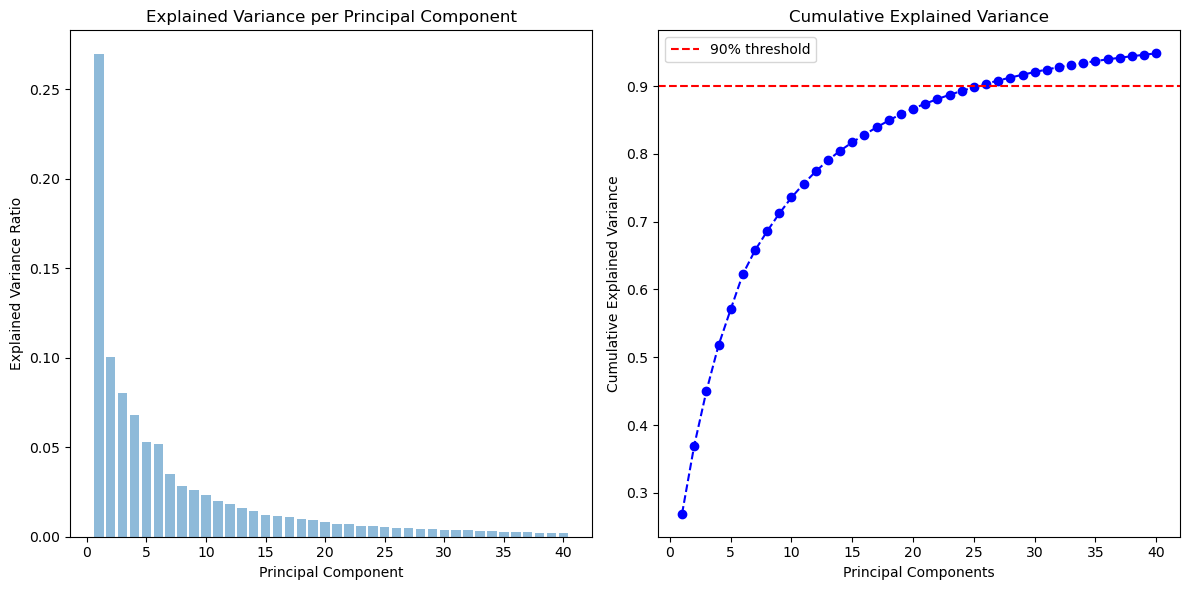

                                      PC1       PC2
egypt_10y_yield                  0.344686 -0.079979
egypt_cpi_yoy                    0.320167 -0.025511
turkey_equity_index              0.318199 -0.085869
china_consumer_confidence_index -0.306232 -0.132083
USD/TRY                          0.261517 -0.014717
egypt_equity_index_EGX30         0.245811 -0.153274
EGP/USD                          0.243474 -0.083676


In [34]:
#Run PCA on polynomial features for the entire dataset
poly_loadings, features_reduced = fit_visualize_pca(poly_scaled_df,40)

#List loadings loadings for the first 2 PCs of the whole dataset
first_poly_loadings = poly_loadings[[1,2]]
poly_loadings_df = pd.DataFrame(poly_loadings, columns=[f'PC{i+1}' for i in range(poly_loadings.shape[1])], index=features_reduced.columns)
selected_PC = ['PC1', 'PC2']
print(loadings_df[selected_PC].sort_values(by = 'PC1',key = abs, ascending = False).head(7))

It seems like the 3rd degree polynomials does not explain variance better in the dataset. It requires 25 PCs to explain 90% of variance while with the initial features it only takes 9 PCs. This means that the underlying factors behind the variance of the features determining grain prices are likely closer to linear in nature.

However this was only for the entire timeframe, I will check the 5 year rolling windows once again, for the polynomial features.


            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2010-01-31                        -0.198508              -1.638432  0.615234   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2010-01-31          -2.657575   0.732418  -0.458419   1.782484   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2010-01-31                               0.135525         0.518329   

            turkey_10y_yield  ...  egypt_money_supply_m2^2 EGP/USD  \
Date                          ...                                    
2010-01-31         -0.241155  ...                        -1.957686   

            egypt_money_supply_m2^2 egypt_equity_index_EGX30  \
Date                                                           
2010-01-31

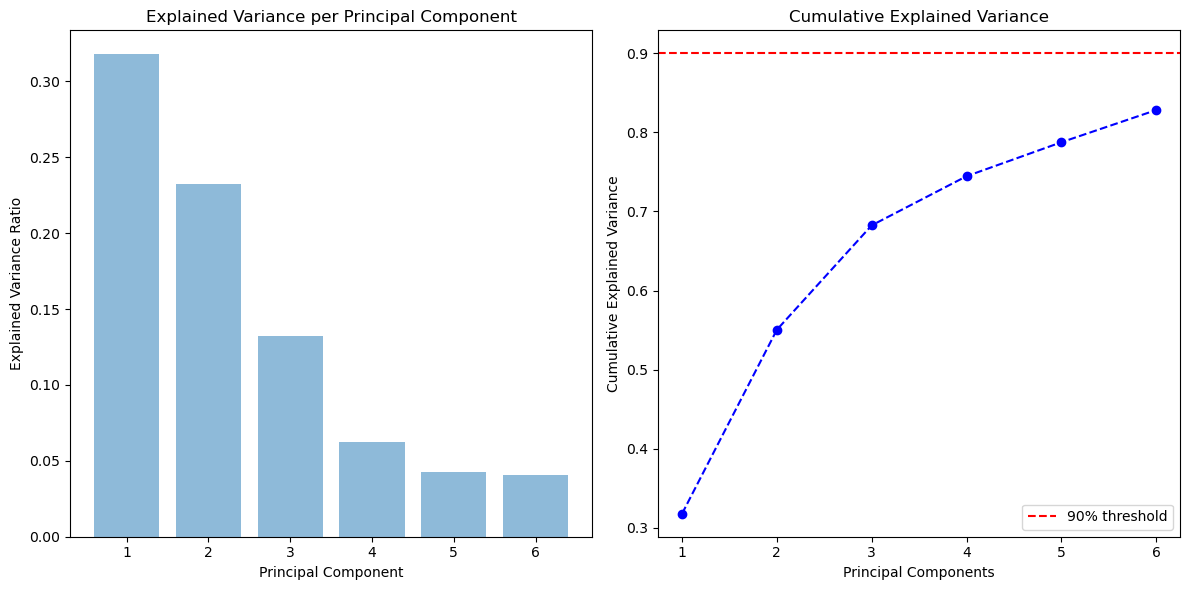

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2011-12-31                        -0.550201               -1.19148 -0.945618   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2011-12-31          -0.156904   0.152083   1.347782   0.750885   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2011-12-31                              -1.482848         0.270041   

            turkey_10y_yield  ...  egypt_money_supply_m2^2 EGP/USD  \
Date                          ...                                    
2011-12-31         -0.520369  ...                        -1.232488   

            egypt_money_supply_m2^2 egypt_equity_index_EGX30  \
Date                                                           
2011-12-31

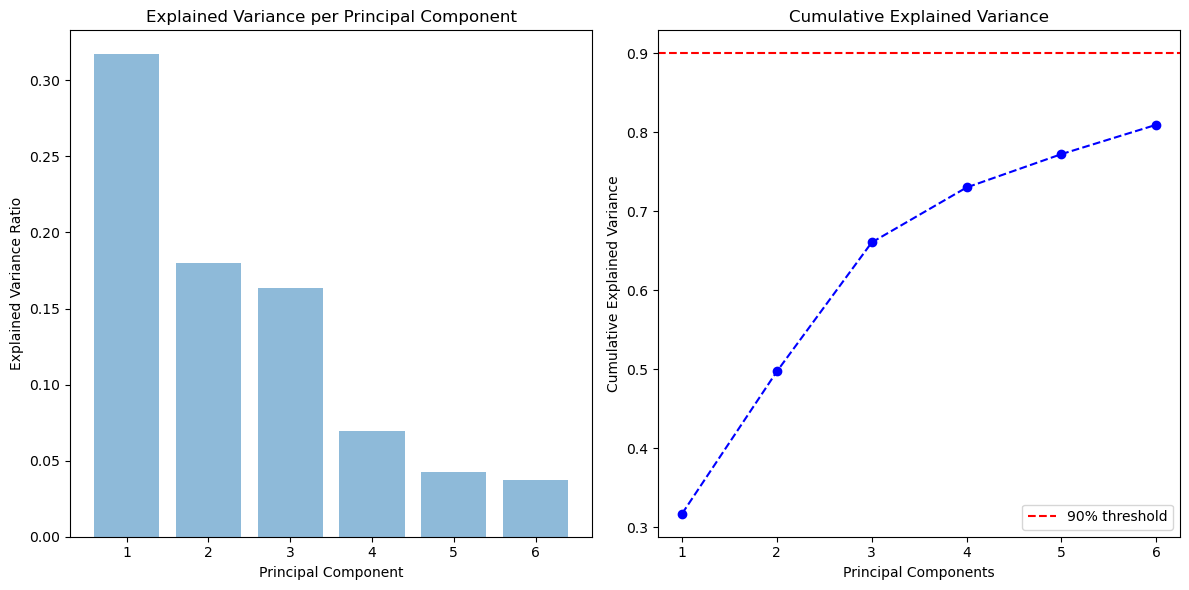

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2012-12-31                        -0.282244              -0.975708 -1.135149   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2012-12-31           0.263967  -0.651459   0.236274   0.343296   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2012-12-31                              -1.340017         0.556527   

            turkey_10y_yield  ...  egypt_money_supply_m2^2 EGP/USD  \
Date                          ...                                    
2012-12-31         -0.555271  ...                         -0.78079   

            egypt_money_supply_m2^2 egypt_equity_index_EGX30  \
Date                                                           
2012-12-31

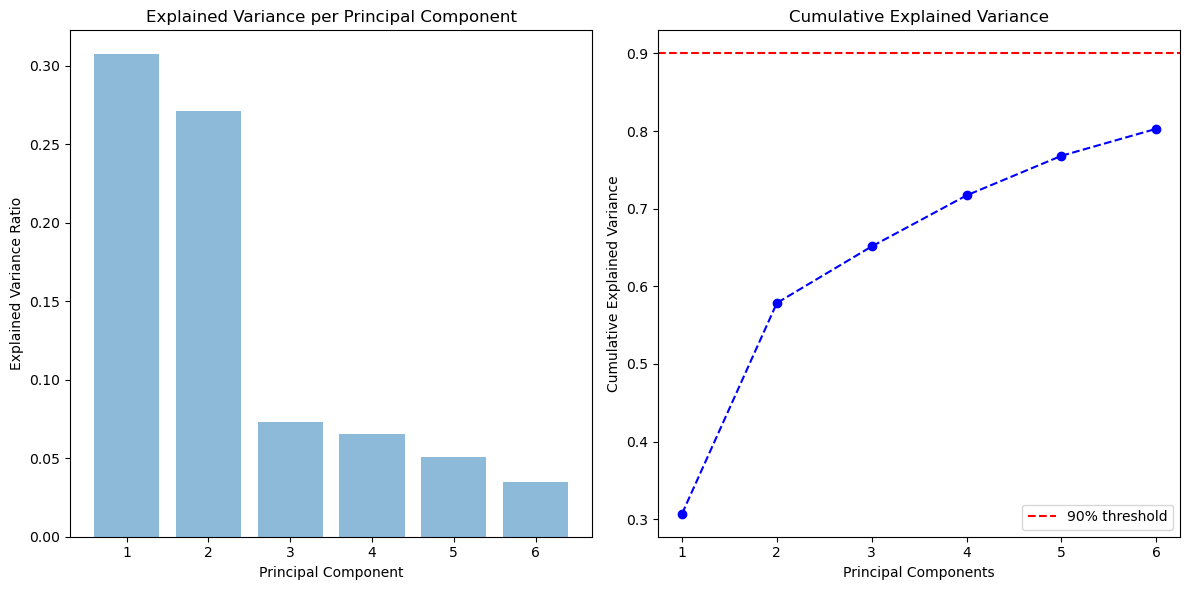

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2013-08-31                         -0.77629              -0.801089 -1.458762   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2013-08-31           1.057516  -0.584497   0.305743   0.227872   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2013-08-31                              -1.689859         1.415984   

            turkey_10y_yield  ...  egypt_money_supply_m2^2 EGP/USD  \
Date                          ...                                    
2013-08-31         -0.473833  ...                        -0.544627   

            egypt_money_supply_m2^2 egypt_equity_index_EGX30  \
Date                                                           
2013-08-31

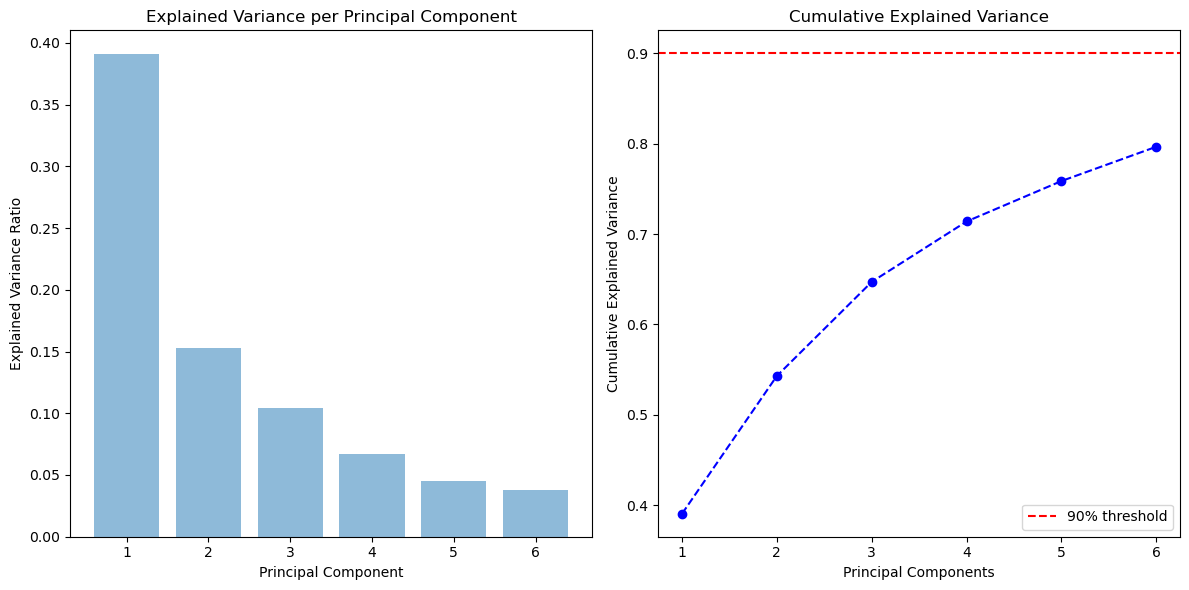

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2014-12-31                        -0.106397              -0.549663 -1.207324   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2014-12-31           1.994468  -0.963947  -0.458419   0.076378   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2014-12-31                               0.638296         0.671121   

            turkey_10y_yield  ...  egypt_money_supply_m2^2 EGP/USD  \
Date                          ...                                    
2014-12-31          -0.99542  ...                        -0.072147   

            egypt_money_supply_m2^2 egypt_equity_index_EGX30  \
Date                                                           
2014-12-31

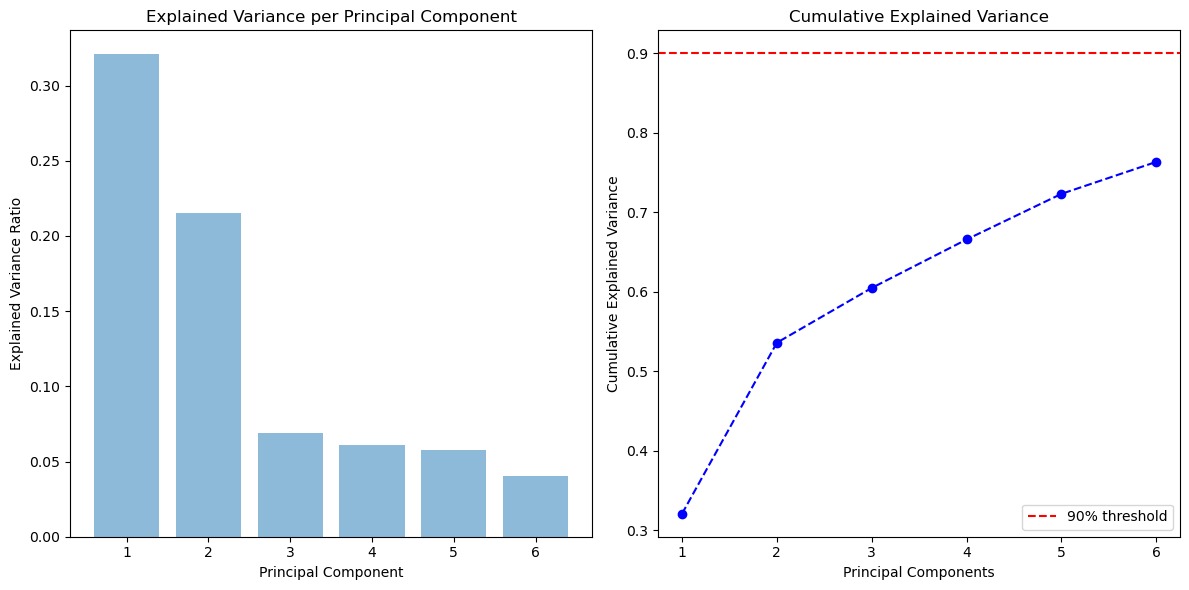

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2015-11-30                         -0.24875              -0.377762 -0.641956   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2015-11-30           0.682879  -1.544282  -0.458419  -0.013796   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2015-11-30                               1.070054        -0.335399   

            turkey_10y_yield  ...  egypt_money_supply_m2^2 EGP/USD  \
Date                          ...                                    
2015-11-30         -0.375914  ...                        -0.101396   

            egypt_money_supply_m2^2 egypt_equity_index_EGX30  \
Date                                                           
2015-11-30

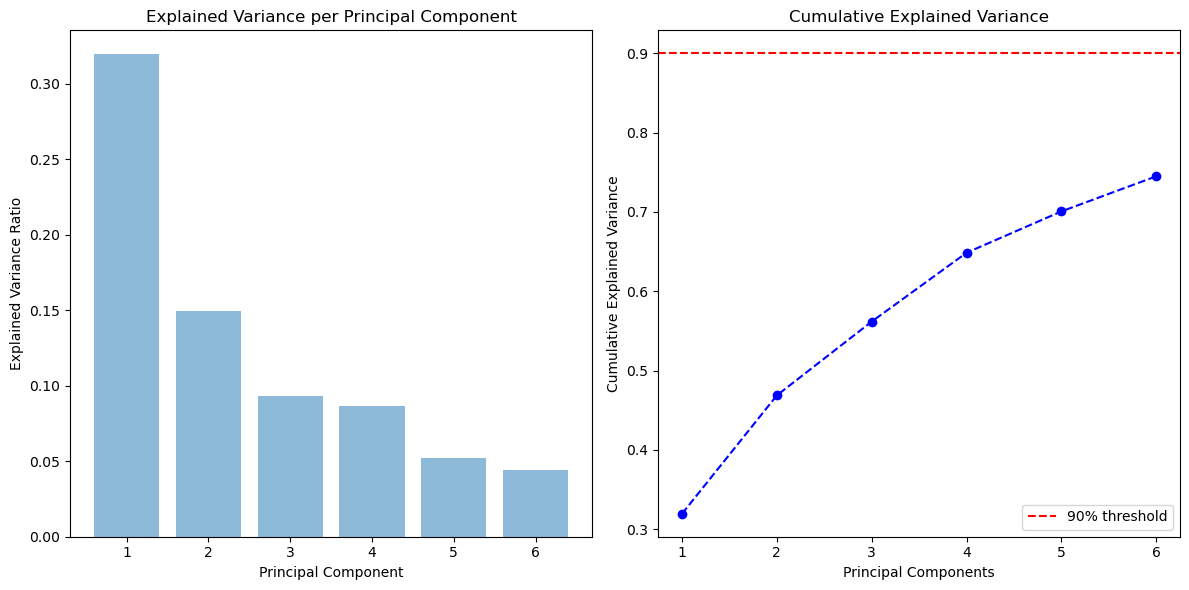

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2016-12-31                         0.111318              -0.291146  0.961731   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2016-12-31          -0.713874   1.000265  -0.041603  -0.024617   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2016-12-31                               0.369807        -0.455723   

            turkey_10y_yield  ...  egypt_money_supply_m2^2 EGP/USD  \
Date                          ...                                    
2016-12-31         -0.754017  ...                         0.901555   

            egypt_money_supply_m2^2 egypt_equity_index_EGX30  \
Date                                                           
2016-12-31

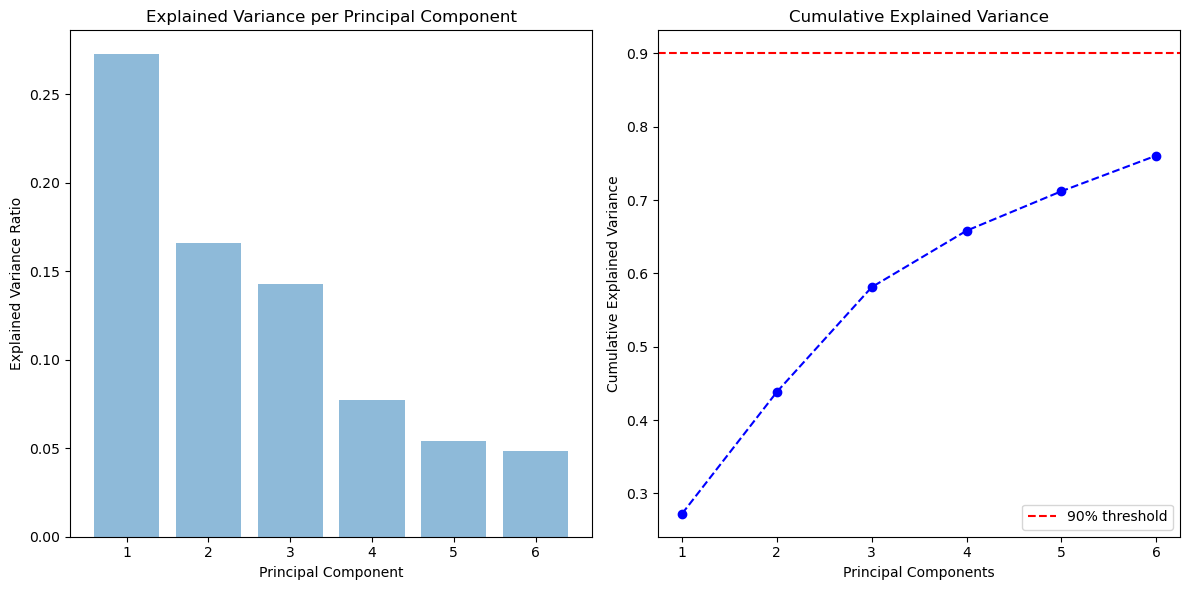

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2017-01-31                         0.178307               -0.23239  0.782761   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2017-01-31          -0.754077   1.312753   0.236274  -0.107578   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2017-01-31                                0.48358         0.126798   

            turkey_10y_yield  ...  egypt_money_supply_m2^2 EGP/USD  \
Date                          ...                                    
2017-01-31         -0.586294  ...                         1.126108   

            egypt_money_supply_m2^2 egypt_equity_index_EGX30  \
Date                                                           
2017-01-31

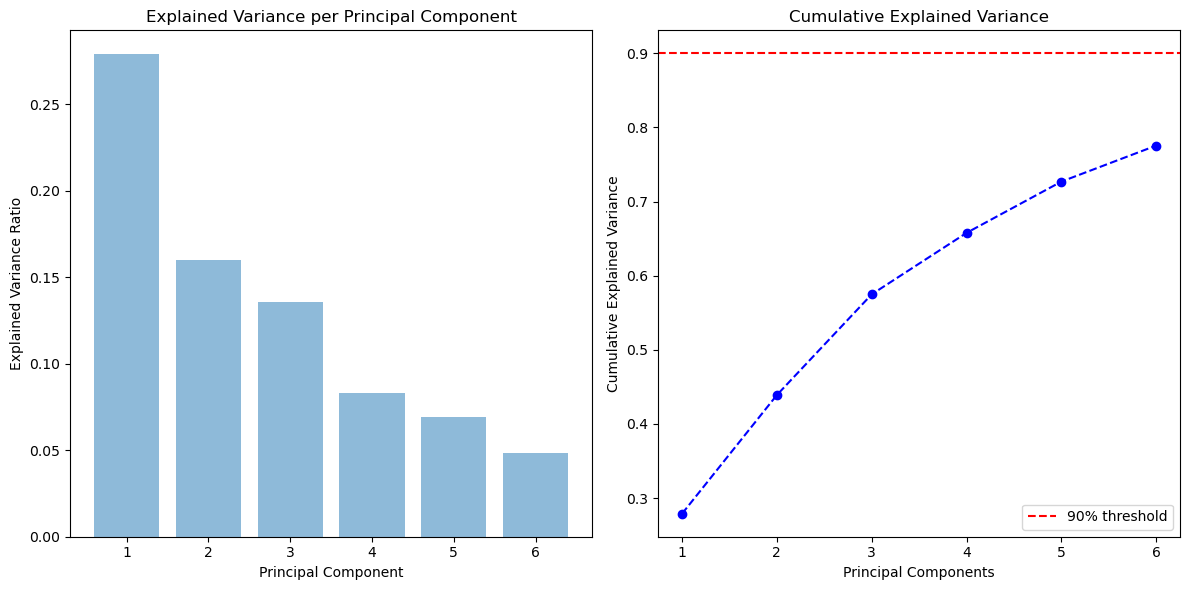

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2018-12-31                         1.333872               0.142898  0.766625   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2018-12-31          -0.510807  -0.026482  -0.180542  -0.168897   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2018-12-31                              -0.879491         0.021753   

            turkey_10y_yield  ...  egypt_money_supply_m2^2 EGP/USD  \
Date                          ...                                    
2018-12-31         -0.292538  ...                         0.025186   

            egypt_money_supply_m2^2 egypt_equity_index_EGX30  \
Date                                                           
2018-12-31

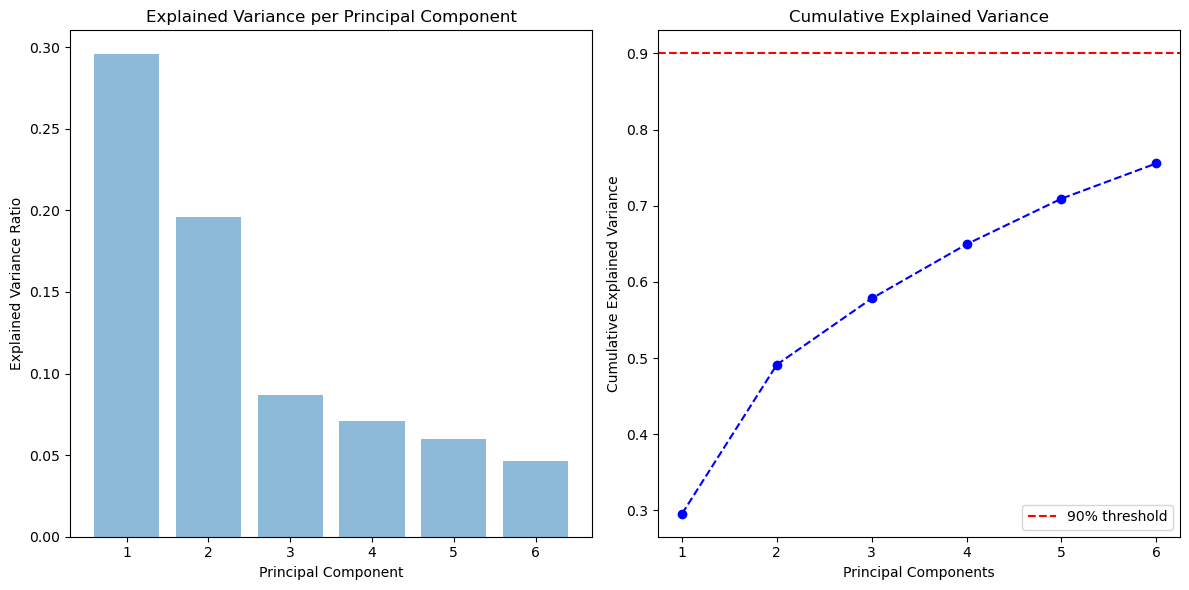

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2019-09-30                         1.425982               0.220056  1.558199   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2019-09-30          -0.446416  -0.495214    0.58362  -0.179718   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2019-09-30                              -0.036793         -0.30102   

            turkey_10y_yield  ...  egypt_money_supply_m2^2 EGP/USD  \
Date                          ...                                    
2019-09-30         -0.156809  ...                        -0.046011   

            egypt_money_supply_m2^2 egypt_equity_index_EGX30  \
Date                                                           
2019-09-30

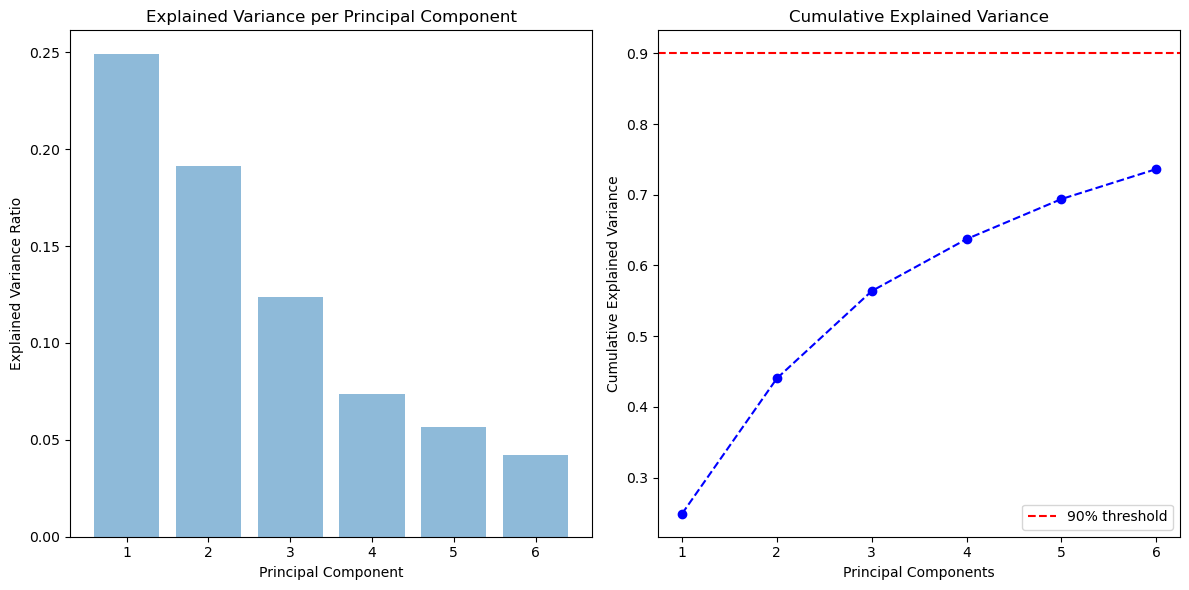

            china_consumer_confidence_index  china_money_supply_m2   CNY/USD  \
Date                                                                           
2020-12-31                         1.258509               0.854216 -0.264065   

            china_fx_reserves  china_ppi  china_cpi  china_gdp  \
Date                                                             
2020-12-31          -0.041254   -0.31665  -1.361519  -0.035438   

            china_equity_shanghai_composite_index  china_10y_yield  \
Date                                                                 
2020-12-31                               1.126735        -0.291471   

            turkey_10y_yield  ...  egypt_money_supply_m2^2 EGP/USD  \
Date                          ...                                    
2020-12-31         -0.043378  ...                         0.227895   

            egypt_money_supply_m2^2 egypt_equity_index_EGX30  \
Date                                                           
2020-12-31

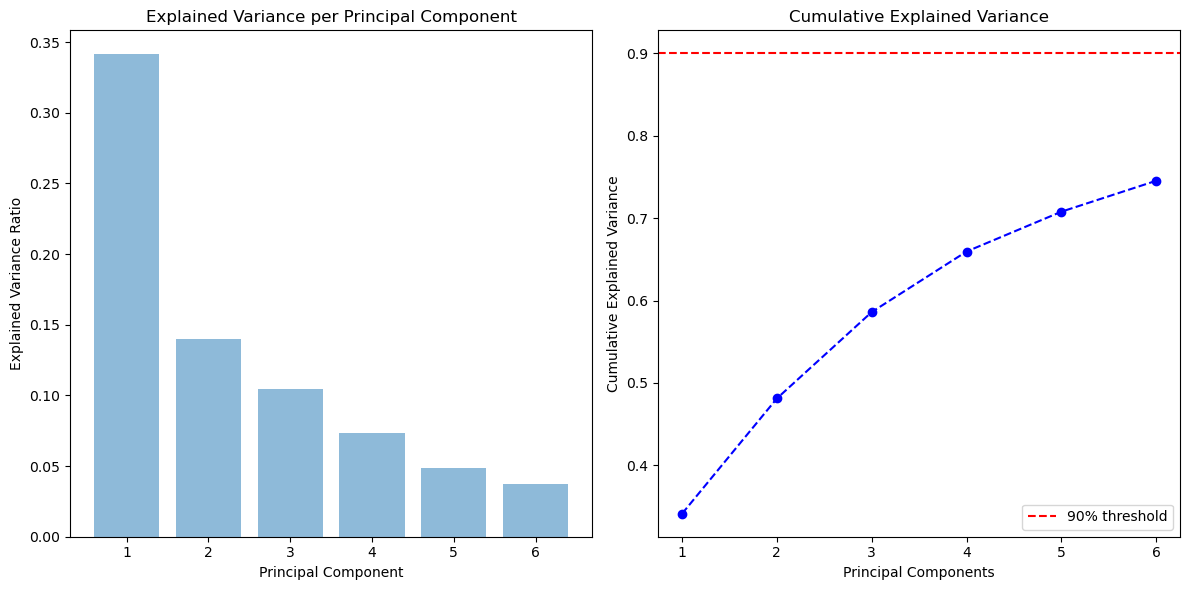

In [36]:

#fixes 5 yearly PCA
poly_scaled_df['Year'] = poly_scaled_df.index.year

# Sort the data by year to ensure proper grouping
poly_sorted_df = poly_scaled_df.sort_values(by='Year')

# Get unique years for rolling 5-year windows
unique_years = poly_sorted_df['Year'].unique()

# Initialize a dictionary to store PCA results
pca_results_poly = {}

# Loop over each 5-year rolling window
for i in range(len(unique_years) - 4):
    #5 yr window
    window_years = unique_years[i:i+5]
    
    # Filter the data for the current 5-year window
    five_year_poly = poly_sorted_df[poly_sorted_df['Year'].isin(window_years)]

    # Apply PCA on the 5-year data for the first 6 PCs
    loadings = fit_visualize_pca(five_year_poly, 6)
    
    # Store the PCA results with the last year of the window as the key
    pca_results_poly[window_years[-1]] = loadings

In [37]:
# Iterate over rolling windows in pca_results
for year, (loadings, features_reduced) in pca_results_poly.items():
    print(f"\nRolling window: {year-4}-{year}")
    
    # Select the first and second principal component loadings
    selected_loadings = loadings[:, [0, 1]]  # PC1 and PC2
    print(year)
    # Create a DataFrame for PC1 and PC2 loadings
    loadings_df = pd.DataFrame(
        selected_loadings,
        columns=[f'PC{i+1}' for i in range(selected_loadings.shape[1])],
        index=features_reduced.columns
    )
    
    # Sort by absolute values of PC1 and display the top 4 features
    print("\nTop 4 features sorted by PC1 absolute loadings:")
    print(loadings_df[['PC1', 'PC2']].sort_values(by='PC1', key=lambda x: x.abs(), ascending=False).head(4))



Rolling window: 2010-2014
2014

Top 4 features sorted by PC1 absolute loadings:
                                                         PC1       PC2
china_fx_reserves USD/IDR EGP/USD                  -0.033621 -0.000765
china_fx_reserves egypt_money_supply_m2 EGP/USD    -0.033461 -0.001274
china_fx_reserves egypt_money_supply_m2 egypt_e... -0.033275 -0.001320
china_money_supply_m2 china_fx_reserves USD/IDR    -0.033264  0.002714

Rolling window: 2011-2015
2015

Top 4 features sorted by PC1 absolute loadings:
                                                         PC1       PC2
china_equity_shanghai_composite_index turkey_mo... -0.030647 -0.000593
china_equity_shanghai_composite_index turkey_cu... -0.030583  0.020172
china_equity_shanghai_composite_index indonesia... -0.030044  0.019184
USD/IDR^2 italy_10y_yield                           0.029908  0.000225

Rolling window: 2012-2016
2016

Top 4 features sorted by PC1 absolute loadings:
                                               

For the 3rd degree polynomials for 90% explained variance a lot more PCs are required. However this is only due to the larger number of features.

The main reason I did the 3rd degree polynomial PCA to see how the loadings changed.

This further confirms my case that chinese indicators are more important in the overall dataset. The largest loadings of the first PCs contain a larger share of chinese indicators than they did for the original feature set.


### 4. Time Series analysis

To run models on the dataset I need to analyze stationarity

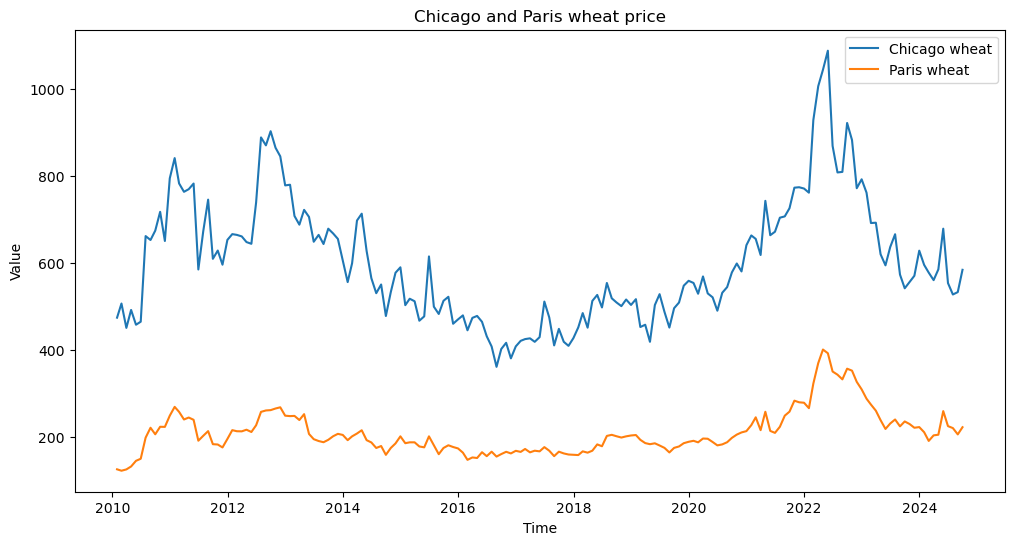

Chicago wheat stationarity:
ADF Test Statistic: -2.6266171733932615
p-value: 0.0876198685085175
Conclusion: The series is non-stationary (fail to reject null hypothesis).
KPSS Test Statistic: 0.2759463426483596
p-value: 0.1
Conclusion: The series is stationary (fail to reject null hypothesis).
Paris wheat stationarity:
ADF Test Statistic: -1.834157940205017
p-value: 0.3636398803426456
Conclusion: The series is non-stationary (fail to reject null hypothesis).
KPSS Test Statistic: 0.4919167883475017
p-value: 0.04348720983164377
Conclusion: The series is non-stationary (reject null hypothesis).


C:\Users\Dell\AppData\Local\Temp\ipykernel_24224\1779718448.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(time_series, regression='c', nlags="auto")


In [40]:
from statsmodels.tsa.stattools import adfuller, kpss

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(wheat_price['chicago_wheat'], label="Chicago wheat")
plt.plot(wheat_price['paris_wheat'], label="Paris wheat")
plt.title("Chicago and Paris wheat price")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

# ADF Test
def adf_test(time_series):
    adf_result = adfuller(time_series)
    print("ADF Test Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    if adf_result[1] < 0.05:
        print("Conclusion: The series is stationary (reject null hypothesis).")
    else:
        print("Conclusion: The series is non-stationary (fail to reject null hypothesis).")

# KPSS Test
def kpss_test(time_series):
    kpss_result = kpss(time_series, regression='c', nlags="auto")
    print("KPSS Test Statistic:", kpss_result[0])
    print("p-value:", kpss_result[1])
    if kpss_result[1] > 0.05:
        print("Conclusion: The series is stationary (fail to reject null hypothesis).")
    else:
        print("Conclusion: The series is non-stationary (reject null hypothesis).")

print('Chicago wheat stationarity:')
adf_test(wheat_price['chicago_wheat'])
kpss_test(wheat_price['chicago_wheat'])

print('Paris wheat stationarity:')
adf_test(wheat_price['paris_wheat'])
kpss_test(wheat_price['paris_wheat'])

According to ADF test both series are non-stationary.
According to KPSS test Paris wheat is non-stationary bust chicago wheat is stationary.
This can mean that the paris wheat price is a trend-stationary process. In this case there is a deterministic trend that if removed, the series can be stationary.

I will use 1st order differences to account for non-stationarity in the dataset.


In [103]:
#Make series stationary by 1st difference
X = aggregate_df

wheat_price['paris_diff'] = wheat_price['paris_wheat'].diff(1)
wheat_price['chicago_diff'] = wheat_price['chicago_wheat'].diff(1)
X = X.loc[wheat_price['paris_diff'].dropna().index]
X_poly = poly_scaled_df.loc[wheat_price['paris_diff'].dropna().index]
wheat_price.dropna(inplace = True)

adf_test(wheat_price['paris_diff'])
kpss_test(wheat_price['paris_diff'])

adf_test(wheat_price['chicago_diff'])
kpss_test(wheat_price['chicago_diff'])

ADF Test Statistic: -12.742660805319181
p-value: 8.875930196536681e-24
Conclusion: The series is stationary (reject null hypothesis).
KPSS Test Statistic: 0.08583325125438124
p-value: 0.1
Conclusion: The series is stationary (fail to reject null hypothesis).
ADF Test Statistic: -11.536455129393863
p-value: 3.723201781806225e-21
Conclusion: The series is stationary (reject null hypothesis).
KPSS Test Statistic: 0.08056844169594429
p-value: 0.1
Conclusion: The series is stationary (fail to reject null hypothesis).


C:\Users\Dell\AppData\Local\Temp\ipykernel_24224\1779718448.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(time_series, regression='c', nlags="auto")
C:\Users\Dell\AppData\Local\Temp\ipykernel_24224\1779718448.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(time_series, regression='c', nlags="auto")


#### LASSO regression




In [151]:
#Prepare variables for lasso regression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score




y1 = wheat_price['paris_diff']
y2 = wheat_price['chicago_diff']

#use chronological train-test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y1_train, y1_test = y1[:train_size], y1[train_size:]
y2_train, y2_test = y2[:train_size], y2[train_size:]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train) 
# Set up range of alpha values for Lasso regularization
lasso_alpha_values = np.logspace(-4, 1, 50)

For some reason hyperparameter optimization is not working correctly with LASSO, it zeros every feature. I am using manual alphas.

In [85]:
# Lasso model with a manual alpha value
lasso_model = Lasso(alpha=0.6)  # Set an initial alpha for testing

# Fit the Lasso model for y1 (paris_diff)
lasso_model.fit(X_scaled, y1_train)
y1_pred = lasso_model.predict(X_test)

# Evaluate model for y1
mse_y1 = mean_squared_error(y1_test, y1_pred)
r2_y1 = r2_score(y1_test, y1_pred)

# Output the results for y1
print(f"Mean Squared Error for y1: {mse_y1}")
print(f"R-squared for y1: {r2_y1}")

# Display non-zero coefficients for y1
significant_features_y1 = {
    feature: coef for feature, coef in zip(X.columns, lasso_model.coef_) if coef != 0
}
print("Significant features for y1 (non-zero coefficients):")
for feature, coef in significant_features_y1.items():
    print(f"{feature}: {coef}")

# Fit the Lasso model for y2 (chicago_diff)
lasso_model.fit(X_scaled, y2_train)
y2_pred = lasso_model.predict(X_test)

# Evaluate model for y2
mse_y2 = mean_squared_error(y2_test, y2_pred)
r2_y2 = r2_score(y2_test, y2_pred)

# Output the results for y2
print(f"Mean Squared Error for y2: {mse_y2}")
print(f"R-squared for y2: {r2_y2}")

# Display non-zero coefficients for y2
significant_features_y2 = {
    feature: coef for feature, coef in zip(X.columns, lasso_model.coef_) if coef != 0
}
print("Significant features for y2 (non-zero coefficients):")
for feature, coef in significant_features_y2.items():
    print(f"{feature}: {coef}")

Mean Squared Error for y1: 345.8623104866049
R-squared for y1: -0.16212326889952844
Significant features for y1 (non-zero coefficients):
china_consumer_confidence_index: -2.6929835801872546
china_ppi: -0.29091753680830507
china_cpi: 0.30571320375695976
turkey_10y_yield: -1.1823842127254716
turkey_consumer_confidence_index: -1.3705515576033978
italy_cpi: 1.1081303466218766
italy_consumer_confidence_index: -0.7643506488364441
italy_current_account_balance: 0.7260045162104672
italy_10y_yield: 0.6444075232287393
egypt_money_supply_m2: -1.1211498222329177
Mean Squared Error for y2: 5300.875439378307
R-squared for y2: 0.003765812776696631
Significant features for y2 (non-zero coefficients):
china_consumer_confidence_index: -10.166860496334479
china_ppi: 2.2138018179882932
china_cpi: 7.705508867075316
china_gdp: 0.6918585254986409
china_equity_shanghai_composite_index: 2.880983530774498
china_10y_yield: -4.294575607302878
turkey_10y_yield: -8.092367930360828
turkey_money_supply_m2: 0.94090123

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


#### LASSO with polynomial features


In [119]:
#Prepare variables for lasso regression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score




y1 = wheat_price['paris_diff']
y2 = wheat_price['chicago_diff']


#use chronological train-test split
train_size = int(0.5 * len(X))
X_train, X_test = X_poly[:train_size], X_poly[train_size:]
y1_train, y1_test = y1[:train_size], y1[train_size:]
y2_train, y2_test = y2[:train_size], y2[train_size:]


# Set up range of alpha values for Lasso regularization
lasso_alpha_values = np.logspace(-4, 1, 50)

In [129]:
# Lasso model with a manual alpha value
lasso_model = Lasso(alpha=0.005)  # Set an initial alpha for testing

# Fit the Lasso model for y1 (paris_diff)
lasso_model.fit(X_train, y1_train)
y1_pred = lasso_model.predict(X_test)

# Evaluate model for y1
mse_y1 = mean_squared_error(y1_test, y1_pred)
r2_y1 = r2_score(y1_test, y1_pred)

# Output the results for y1
print(f"Mean Squared Error for y1: {mse_y1}")
print(f"R-squared for y1: {r2_y1}")

# Display non-zero coefficients for y1
significant_features_y1 = {
    feature: coef for feature, coef in zip(X.columns, lasso_model.coef_) if coef != 0
}
print("Significant features for paris wheat (non-zero coefficients):")
for feature, coef in significant_features_y1.items():
    print(f"{feature}: {coef}")

# Fit the Lasso model for y2 (chicago_diff)
lasso_model.fit(X_train, y2_train)
y2_pred = lasso_model.predict(X_test)

# Evaluate model for y2
mse_y2 = mean_squared_error(y2_test, y2_pred)
r2_y2 = r2_score(y2_test, y2_pred)

# Output the results for y2
print(f"Mean Squared Error for y2: {mse_y2}")
print(f"R-squared for y2: {r2_y2}")

# Display non-zero coefficients for y2
significant_features_y2 = {
    feature: coef for feature, coef in zip(X.columns, lasso_model.coef_) if coef != 0
}
print("Significant features for chicago wheat (non-zero coefficients):")
for feature, coef in significant_features_y2.items():
    print(f"{feature}: {coef}")

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.080e+01, tolerance: 2.668e+00
  model = cd_fast.enet_coordinate_descent(


Mean Squared Error for y1: 462.9587833934489
R-squared for y1: -1.1379174961365348
Significant features for paris wheat (non-zero coefficients):
italy_10y_yield: 1.8690260451593514
Mean Squared Error for y2: 6346.130615261649
R-squared for y2: -0.8348239129103567
Significant features for chicago wheat (non-zero coefficients):
china_consumer_confidence_index: -5.152423641606813
china_cpi: 5.285344518589526
turkey_cpi: 0.0957621992835335
turkey_ppi: 1.2190673987651375
indonesia_cpi: 4.405155618909294
indonesia_equity_index_JKSE: 0.13702350858813192
italy_cpi: 0.09367959799748155
italy_money_supply_m2: -1.9651970856842442
italy_10y_yield: 4.31689942171174
egypt_10y_yield: 0.06433286623389103
egypt_money_supply_m2: -0.44079163305704905


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.514e+02, tolerance: 2.581e+01
  model = cd_fast.enet_coordinate_descent(


LASSO performed very poorly on the dataset. It would require further examination. 

### Conclusion


The dataset was collected to investigate how macroeconomic and financial indices of major grain-importing countries interact with wheat price dynamics. Principal Component Analysis (PCA) was employed to identify the primary drivers of variance across the features.

Applying PCA to the full dataset revealed that 9 principal components accounted for over 90% of the variance, reducing the dimensionality of 39 features. This indicates that a small subset of indices can explain the majority of market movements, which aligns with the global nature of grain price drivers. To account for potential time-varying effects, PCA was also applied using a 5-year rolling window, enabling an analysis of how the composition of variance changes annually. Both the overall dataset and the rolling window analysis highlighted that the China equity index and related Chinese macroeconomic indicators were consistently the largest contributors to variance. This finding aligns with China's dominant role in global grain demand.

Upon examining the correlation matrix, no strong linear correlations were identified between the Chicago and Paris wheat price indices and the macroeconomic features. To capture potential nonlinear relationships, polynomial features were introduced. This adjustment further amplified the influence of Chinese indices on the loadings of the first two principal components, reinforcing their significance in explaining market variance.

Given the non-stationarity of wheat prices, first differences were taken to ensure stationarity for further modeling. LASSO regression was applied to both the original and polynomially transformed features, but the results were suboptimal, with negative R2 values indicating poor model performance. Furthermore, the most significant features selected by LASSO didn't prove to be useful, possibly due to the complexity of interactions or insufficient feature engineering.

For future analysis, tree-based models may offer more flexibility in capturing nonlinear and interactive effects. I would like to explore predictive analysis later on, I think this dataset and conclusions could prove to be helpful with that aswell.